# <strong><font color = orange> Sentiment Based Product Recommendation System </strong></font>

## <strong><font color = orange> <u> About the Project </u> </strong></font>

  The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

 Suppose you are working as a Machine Learning Engineer in an e-commerce company named <strong>'Ebuss'</strong>. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders. </font>

## <strong><font color = orange> <u> Business Objective</u> </strong></font>
As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. </font>

In-order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks:
1. Data sourcing and sentiment analysis
2. Building a recommendation system
3. Improving the recommendations using the sentiment analysis model
4. Deploying the end-to-end project with a user interface </font>



 # <strong><font color = orange> <u>  Build Sentiment Classification Models </u> </strong></font>

## <font color = orange> <strong> <center> <u> SCAFFOLDING: Importing necessary libraries </u> </center> </strong> </font>

In [1]:
!pip install google-re2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.8/546.8 kB 25.4 MB/s eta 0:00:00


In [2]:
import nltk
import json
import numpy as np
import re2
import spacy
import string
import en_core_web_sm
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# from imblearn.over_sampling import SMOTE
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, precision_score, recall_score, f1_score,
                             RocCurveDisplay, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics.pairwise import pairwise_distances
from pprint import pprint

# Load spaCy model
nlp = en_core_web_sm.load()

# Download NLTK resources
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')


import pandas as pd

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 300)
pd.set_option('display.precision', 2)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## <font color = orange> <strong> <center> <u> UTILITIES: Helper methods </u> </center> </strong> </font>

In [3]:
# Utility functions to plot pie chart for data-types in the dataset

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

def plot_datatype_pie_chart(dataframe):
    type_to_columns_dict = dataframe.columns.to_series().groupby(dataframe.dtypes).groups
    types_list = list(type_to_columns_dict.keys())

    type_to_fdCount_dict = dict.fromkeys(types_list)
    for key in types_list:
        type_to_fdCount_dict.update({key:len(type_to_columns_dict[key])})

    df = pd.DataFrame(type_to_fdCount_dict,index=['count']).transpose()
    explode_values = list()
    explode_values.append(0)
    for i in range(1,len(df)):
        explode_values.append(explode_values[i-1]+0.1)

    df.plot.pie(y='count',legend=False, figsize=(8, 8),autopct= autopct_format(df["count"]),
                explode=explode_values, shadow=True, startangle=0)
    plt.title("Datatype distribution for the dataset - {}".format(dataframe.attrs["name"]))
    plt.show()


# Utility function to attach a 'name' attribute tot he dataframe. Acts like metadata
def add_attribute(dataframe,attrKey,attrValue):
    dataframe.attrs[attrKey] = attrValue

# Utility method to plot box and displot side-by-side given a dataframe
def dist_box_plot(dataframe):
    for column in dataframe.columns:
        plt.figure(figsize=(15,5))

        plt.subplot(1,2,1)
        plt.title(column, fontdict={'fontsize': 12})
        sns.distplot(dataframe[column])

        plt.subplot(1,2,2)
        sns.boxplot(dataframe[column])
        plt.show()

In [4]:
import pandas as pd

def style_null_summary(df):
    # Filter columns with NULL values
    null_columns = df.columns[df.isna().any()]

    # Count NULL values in each column
    null_count = df[null_columns].isna().sum().sort_values(ascending=False)

    # Calculate percentage of NULL values in each column and format it to three decimal places
    null_percentage = (df[null_columns].isna().sum() * 100 / df.shape[0]).sort_values(ascending=False)
    null_percentage = null_percentage.map('{:.3f}%'.format)

    # Combine the count and formatted percentage into a DataFrame
    null_data = pd.DataFrame({
        'Count': null_count,
        'Percentage': null_percentage
    })

    # Add a numbering column
    null_data.reset_index(drop=False, inplace=True)
    null_data.rename(columns={'index': 'Column Number'}, inplace=True)

    # Function to determine cell color based on percentage
    def color_percentage(val):
        if isinstance(val, str) and '%' in val:
            percentage = float(val[:-1])  # Convert percentage string to float
            if percentage > 70:
                return 'background-color: red'
            elif 30 <= percentage <= 70:
                return 'background-color: orange'
            else:
                return 'background-color: green'
        return ''

    # Style the DataFrame
    styled_null_data = null_data.style.applymap(
        color_percentage,
        subset=['Percentage']
    ).applymap(
        lambda x: 'background-color: coral' if isinstance(x, int) and x > 0 else '',
        subset=['Count']
    )

    return styled_null_data

In [5]:
def plot_column_distribution_graph(dataframe, column_name):
    # Count occurrences of each unique value in the specified column, including NaN
    value_counts = dataframe[column_name].value_counts(dropna=False)

    # Calculate the percentage for each value
    percentages = (value_counts / len(dataframe)) * 100

    # Create a color map based on unique values
    colors = plt.cm.tab10(range(len(value_counts)))  # Using a colormap for distinct colors

    # Plot the distribution
    ax = value_counts.plot(kind='bar', color=colors, figsize=(8, 6))

    plt.title(f'Distribution of {column_name}', fontsize=16)
    plt.xlabel(column_name, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Annotate each bar with its percentage
    for i, value in enumerate(value_counts):
        pct_text = f'{percentages.iloc[i]:.2f}%'  # Format percentage to two decimal places
        ax.text(i, value + 0.02 * value, pct_text, ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_column_distribution_table(dataframe, column_name):
    # Count occurrences of each unique value in the specified column, including NaN
    value_counts = dataframe[column_name].value_counts(dropna=False)

    # Calculate the percentage for each value
    percentage = (value_counts / len(dataframe)) * 100

    # Create a DataFrame for the table with the count and percentage
    table_data = pd.DataFrame({
        column_name: value_counts.index,
        'Count': value_counts.values,
        'Percentage': percentage.map('{:.2f}%'.format)
    })

    # Create the table
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=table_data.values, colLabels=table_data.columns,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.title(f'Distribution Table for {column_name}', fontsize=16)
    plt.show()


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
import numpy as np

def visualize_skewness(df, column_name):
    # Check if column exists in the dataframe
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")

    # Handle non-numeric data by attempting to convert it
    if not pd.api.types.is_numeric_dtype(df[column_name]):
        df[column_name] = pd.to_numeric(df[column_name], errors='coerce')

    # Drop NaN values from the column
    column_data = df[column_name].dropna()

    # If the column is empty after dropping NaNs, raise an error
    if column_data.empty:
        raise ValueError(f"Column '{column_name}' contains no valid numeric data.")

    # Plot the distribution of the column
    plt.figure(figsize=(8, 6))
    sns.histplot(column_data, kde=True, bins=10)
    plt.title(f'Distribution Plot of {column_name}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')

    # Compute skewness
    column_skewness = skew(column_data)
    plt.axvline(column_data.mean(), color='red', linestyle='dashed', linewidth=2, label=f'Skewness: {column_skewness:.2f}')
    plt.legend()

    # Show the plot
    plt.show()

    # Print skewness value and state if it's positive or negative
    print(f"Skewness of '{column_name}': {column_skewness:.2f}")

    if column_skewness > 0:
        print(f"The column '{column_name}' is **positively skewed** (right-skewed).")
    elif column_skewness < 0:
        print(f"The column '{column_name}' is **negatively skewed** (left-skewed).")
    else:
        print(f"The column '{column_name}' is **symmetrical** or very close to symmetrical (minimal skewness).")

In [8]:
import pandas as pd

def unique_value_counts(dataframe):
    """
    Function to list the count of unique values for each column in the DataFrame.

    Parameters:
    - dataframe: The pandas DataFrame to analyze.

    Returns:
    - A DataFrame showing the count of unique values for each column.
    """
    unique_counts = {column: dataframe[column].nunique() for column in dataframe.columns}

    # Create a DataFrame from the unique counts
    unique_counts_df = pd.DataFrame(unique_counts, index=['Unique Count']).T.reset_index()
    unique_counts_df.columns = ['Column', 'Unique Count']

    return unique_counts_df

In [9]:
import pandas as pd
from IPython.display import display, HTML

def display_first_last_unique(dataframe, column_names):
    """
    Function to display the first 10 and last 10 unique values for specified columns
    in the DataFrame, with in-between values represented by dots, along with their counts and percentages.

    Parameters:
    - dataframe: The pandas DataFrame to analyze.
    - column_names: A list of column names for which to display unique values.
    """
    for column_name in column_names:
        if column_name in dataframe.columns:
            total_values = len(dataframe[column_name])
            unique_counts = dataframe[column_name].value_counts()
            unique_values = unique_counts.index.tolist()
            unique_count = len(unique_values)

            # Calculate percentages
            percentages = (unique_counts / total_values) * 100

            if unique_count <= 20:
                displayed_values = unique_counts
                displayed_percentages = percentages
            else:
                displayed_values = pd.Series(unique_counts[:10].tolist() + unique_counts[-10:].tolist(),
                                             index=unique_values[:10] + unique_values[-10:],
                                             name=column_name)
                displayed_percentages = pd.Series(percentages[:10].tolist() + percentages[-10:].tolist(),
                                                  index=unique_values[:10] + unique_values[-10:],
                                                  name=column_name)

            # Create a DataFrame for better formatting
            display_df = pd.DataFrame({
                'Count': displayed_values,
                'Percentage (%)': displayed_percentages
            })

            # Style the DataFrame with HTML
            display_html = f"<h3 style='color: orange;'>Unique values for column '<span style='color: blue;'>{column_name}</span>':</h3>"
            display(HTML(display_html))
            display(display_df.style.format({'Percentage (%)': '{:.2f}%'}).applymap(lambda x: 'color: green;' if x > 0 else ''))

        else:
            print(f"<span style='color: red;'>Column '{column_name}' does not exist in the DataFrame.</span>")

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown

def exploratory_data_analysis(df):
    """
    Function to perform exploratory data analysis focusing only on numeric columns.

    Parameters:
    - df: The pandas DataFrame to analyze.
    """

    # Display first 5 rows of the dataframe
    display(Markdown("### <span style='color:blue;'>First 5 rows of the data:</span>"))
    display(df.head())

    # Summary statistics for numeric columns
    numeric_cols = df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        display(Markdown("### <span style='color:green;'>Summary statistics for numeric columns:</span>"))
        display(df[numeric_cols].describe())
    else:
        display(Markdown("<p style='color:red;'>No numeric columns to analyze.</p>"))
        return

    # Check for missing values in numeric columns
    display(Markdown("### <span style='color:orange;'>Missing values in each numeric column:</span>"))
    display(df[numeric_cols].isnull().sum())

    # Plot the distribution of numeric columns
    if len(numeric_cols) > 0:
        df[numeric_cols].hist(bins=15, figsize=(15, 10), edgecolor='black')
        plt.suptitle("**Histograms of Numeric Columns**", fontsize=16)
        plt.show()

        # Plot boxplots for numeric columns (to detect outliers)
        plt.figure(figsize=(15, len(numeric_cols) * 4))
        for i, col in enumerate(numeric_cols, 1):
            plt.subplot(len(numeric_cols), 1, i)
            sns.boxplot(x=df[col], palette='Set1')
            plt.title(f"**Boxplot of {col}**", fontsize=16)
        plt.tight_layout()
        plt.show()

        # Correlation heatmap for numeric columns
        if len(numeric_cols) > 1:
            plt.figure(figsize=(10, 6))
            correlation = df[numeric_cols].corr()
            sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
            plt.title("**Correlation Heatmap**", fontsize=16)
            plt.show()

        # Pairplot for numeric columns
        if len(numeric_cols) > 1:
            sns.pairplot(df[numeric_cols].dropna(), corner=True)
            plt.suptitle("**Pairplot of Numeric Columns**", y=1.02, fontsize=16)
            plt.show()
    else:
        display(Markdown("<p style='color:red;'>No numeric columns to plot.</p>"))

    # Missing value heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df[numeric_cols].isnull(), cbar=False, cmap='viridis')
    plt.title("**Missing Value Heatmap**", fontsize=16)
    plt.show()

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

def visualize_non_numeric_column(df, column_name):
    """
    Visualize a non-numeric column in the DataFrame.

    Parameters:
    - df: The pandas DataFrame containing the data.
    - column_name: The name of the non-numeric column to visualize.
    """

    # Check if the column exists
    if column_name not in df.columns:
        display(Markdown(f"<p style='color:red;'>Column '{column_name}' not found in the DataFrame.</p>"))
        return

    # Check if the column is non-numeric
    if pd.api.types.is_numeric_dtype(df[column_name]):
        display(Markdown(f"<p style='color:red;'>Column '{column_name}' is numeric. Please provide a non-numeric column.</p>"))
        return

    # Drop missing values for visualization
    column_data = df[column_name].dropna()

    # Countplot for the non-numeric column
    plt.figure(figsize=(12, 8))
    sns.countplot(y=column_name, data=df, palette='Set2', order=column_data.value_counts().index)
    plt.title(f'Countplot of {column_name}', fontsize=16)
    plt.xlabel('Count')
    plt.ylabel(column_name)
    plt.show()

    # Display value counts for the column
    display(Markdown(f"### Value counts for '{column_name}':"))
    display(column_data.value_counts())

In [12]:
import re

def clean_punctuation(sent):
    """
    Cleans the input text by converting it to lowercase and removing punctuation.

    Args:
        sent (str): The input text to be cleaned.

    Returns:
        str: The cleaned text with punctuation removed and in lowercase.
    """
    if not isinstance(sent, str):
        raise ValueError("Input must be a string.")

    # Convert text to lowercase
    sent = sent.lower()

    # Remove punctuation
    pattern = r'[^\w\s]'  # Regex pattern to match any character that is not a word character or whitespace
    cleaned_sent = re.sub(pattern, '', sent)

    return cleaned_sent

In [13]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

# Define the set of stopwords
stopwords_set = set(stopwords.words('english'))

def clean_stopwords(sent):
    if not isinstance(sent, str):
        raise ValueError("Input must be a string.")

    # Convert text to lowercase
    sent = sent.lower()

    # Tokenize the sentence
    words = word_tokenize(sent)

    # Remove stopwords
    text_nostopwords = " ".join([word for word in words if word not in stopwords_set])

    return text_nostopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
def clean_lemma(text):
    doc = nlp(text)
    return " ".join(token.lemma_ for token in doc)

In [15]:
!pip install squarify

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

def colored_print(text, color_code):
    """Print text in a specified color."""
    print(f"\033[{color_code}m{text}\033[0m")

def explore_data_charts(df, column):
    # Check if the column exists
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    # Create 'review_length' column if it doesn't exist
    if 'review_length' not in df.columns:
        df['review_length'] = df['reviews_lemmatized'].apply(len)

    # Radar Chart
    def plot_radar_chart(data, categories):
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        data += data[:1]  # Complete the loop
        angles += angles[:1]  # Complete the loop

        plt.figure(figsize=(8, 8))
        ax = plt.subplot(111, polar=True)
        ax.fill(angles, data, color='blue', alpha=0.25)
        ax.plot(angles, data, color='blue', linewidth=2)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        plt.title("Radar Chart of Metrics")
        plt.show()

        colored_print("\n--- Radar Chart Inference ---", "34")  # Cyan
        colored_print("The radar chart visualizes multiple metrics (e.g., Precision, Recall, F1-Score).", "36")  # Light Cyan
        colored_print("Higher values indicate better performance across the metrics.\n", "37")  # White

        print("\n" + "-" * 50)  # Delimiter

    # Box Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column, y='review_length', data=df, palette='Set2')
    plt.title("Box Plot of Review Lengths by Sentiment")
    plt.xlabel(column)
    plt.ylabel("Review Length")
    plt.show()

    colored_print("\n--- Box Plot Inference ---", "34")  # Cyan
    colored_print("The box plot illustrates the distribution of review lengths for each sentiment.", "36")
    colored_print("Wider boxes indicate more variability in review lengths, while outliers show extreme cases.\n", "37")

    print("\n" + "-" * 50)  # Delimiter

    # Word Cloud
    text = " ".join(review for review in df['reviews_lemmatized'])
    wordcloud = WordCloud(max_font_size=60, background_color="white").generate(text)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Reviews")
    plt.show()

    colored_print("\n--- Word Cloud Inference ---", "34")
    colored_print("The word cloud displays the most frequent words in the reviews.", "36")
    colored_print("Larger words are used more frequently, indicating common themes or sentiments.\n", "37")

    print("\n" + "-" * 50)  # Delimiter

    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(df['review_length'], bins=30, kde=True, color='lightblue')
    plt.title("Histogram of Review Lengths")
    plt.xlabel("Review Length")
    plt.ylabel("Frequency")
    plt.show()

    colored_print("\n--- Histogram Inference ---", "34")
    colored_print("The histogram shows the distribution of review lengths.", "36")
    colored_print("Peaks indicate common review lengths, and the spread reflects variability.\n", "37")

    # Example Radar Chart Data
    categories = ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'AUC']  # More categories
    metrics_data = [0.8, 0.7, 0.75, 0.85, 0.9]  # Example metrics values
    plot_radar_chart(metrics_data, categories)

In [17]:
OBJECT_FILE_PATH = "/content/"

#To save objects at intermediate step
def save_object(obj, filename):
    pkl_filename = OBJECT_FILE_PATH + filename + ".pkl"
    with open(pkl_filename, 'wb') as files:
      pickle.dump(obj, files)

## <font color = orange> <strong> <center> <u> DATA LOADING: Import dataset into the project </u> </center> </strong> </font>

In [18]:
input_file_path = "sample30.csv"
df = pd.read_csv(input_file_path)

In [19]:
df.head()

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                                                                                                                                       categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap   
1                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
2                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
3                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   
4                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   
3                                 K-Y   
4                                 K-Y   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)  2012-11-30T06:21:45.000Z   
1  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
2  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
3            K-Y Love Sensuality Pleasure Gel  2016-01-06T00:00:00.000Z   
4            K-Y Love Sensuality Pleasure Gel  2016-12-21T00:00:00.000Z   

  reviews_didPurchase reviews_doRecommend  reviews_rating  \
0                 NaN                 NaN               5   
1                True                 NaN               5   
2                True                 NaN               5   
3               False               False               1   
4               False               False               1   

                                                                                                                                                                                                                                                                                                  reviews_text  \
0                                                                                                    i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.   
1                                                                                                                                                                                                                                               Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                                                                                                                 Good flavor.   
3  I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...   
4                                                                                                                                                                         

## <font color = orange> <strong> <center> <u> DATA EXPLORATION: Exploratory Data Analysis </u> </center> </strong> </font>

In [20]:
!pip install ydata-profiling
from ydata_profiling import ProfileReport

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 42.7 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=ca136f9917b45dfa5039833c904732a0b2165e0b1b05b932c79bf0ea65089e59
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [21]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
df.shape

(30000, 15)

<strong> Observations</strong>
> 1. Dataset for has 30,000 rows and 15 columns.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

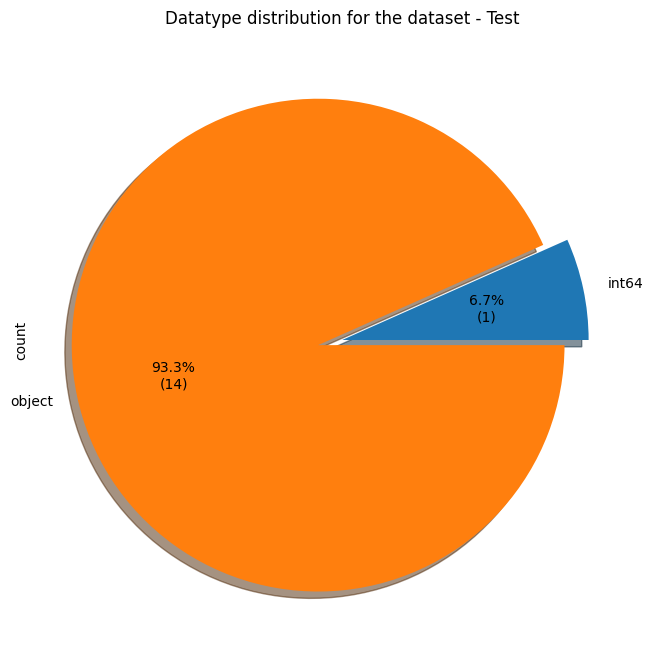

In [24]:
import matplotlib.pyplot as plt

add_attribute(df,"name","Test")
plot_datatype_pie_chart(df)

<strong> Observations</strong>
> 1. Dataset has 15 columns, out of which 14 are of type OBJECT and one column is of type INT64.
> 2. Once the necessary columns are picked up for the analysis, we shall try converting the columns to appropriate datatype.

### Definitions for the columns in the dataset

In [25]:
input_definition_file_path = "/content/Data+Attribute+Description.csv"
df_def = pd.read_csv(input_definition_file_path, encoding='latin1')
df_def.head(30)

Attribute  \
0                     id   
1                  brand   
2             categories   
3           manufacturer   
4                   name   
5           reviews_date   
6    reviews_didPurchase   
7    reviews_doRecommend   
8         reviews_rating   
9           reviews_text   
10         reviews_title   
11      reviews_userCity   
12  reviews_userProvince   
13      reviews_username   
14        user_sentiment   

                                                                                                                                                                                                    Attribute Description  
0                                                                                                         Uniques identity number to identify each unique review given by the user to a particular product in the dataset  
1                                                                                                                                              Name of the brand of the product to which user has given review and rating  
2   Category of the product like household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products, health care products and many more.  
3                                                                                                                                                                                 Name of the manufacturer of the product  
4                                                                                                                                                            Name of the product to which user has added review or rating  
5                                                                                                                                                                     Date on which the review has been added by the user  
6                                                                                                                                                              Whether a particular user has purchased the product or not  
7                                                                                                                                                            Whether a particular user has recommended the product or not  
8                                                                                                                                                                        Rating given by the user to a particular product  
9                                                                                                                                                                        Review given by the user to a particular product  
10                                                                                                                                                      The title of the review given by the user to a particular product  
11                                                                                                                                                                                          The residing city of the user  
12                                                                                                                                                                                      The residing province of the user  
13                                                                                                                                                           The unique identification for individual user in the dataset  
14                                                                                                                                      The overall sentiment of the user for a particular product (Positive or Negative)

## <font color = orange> <strong> <center> <u> DATA CLEANING: Handling NULL values </u> </center> </strong> </font>


In [26]:
styled_null_data = style_null_summary(df)
styled_null_data

<strong> Summary of Data Completeness check for NULL values</strong>
> 1. The columns `reviews_userProvince` (99.43%) and `reviews_userCity` (93.57%) have exceedingly high rates of missing values. Given that nearly all entries lack this information, these columns should be considered for removal from analysis to avoid skewing results.
> 2. The `reviews_didPurchase` column (46.89%) also has a significant amount of missing data, <b>warranting consideration for its relevance in analysis.</b>
> 3. The remaining columns, including `reviews_doRecommend` (8.57%), `reviews_title` (0.63%), `manufacturer` (0.47%), `reviews_username` (0.21%), and `reviews_date` (0.15%), have low percentages of missing values, suggesting they are sufficiently complete for analysis.

<strong> Recommendation</strong>
> - It is advisable to remove `reviews_userProvince` and `reviews_userCity` from the dataset prior to analysis due to their high missing value percentages, while retaining the other columns for a more reliable analysis.
> - For the `reviews_didPurchase` column, consider imputation methods such as:
>   - **Mean/Median Imputation**: If the column is numeric, replace missing values with the mean or median.
>   - **Mode Imputation**: For categorical data, replace missing values with the most frequent category.
>   - **Predictive Modeling**: Use machine learning models to predict and fill missing values based on other available features.
>   - **Dropping Missing Values**: If imputation isn't suitable, consider dropping rows with missing values if they are not significant for analysis.

In [27]:
cleaned_df = df.copy()
add_attribute(cleaned_df,"name","Test")

Remove columns with greater than 70% NULL values:  <b>reviews_userProvince</b>  and <b>reviews_userCity</b></font>

In [28]:
columns_to_drop = ['reviews_userProvince', 'reviews_userCity']
cleaned_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [29]:
cleaned_df.shape

(30000, 13)

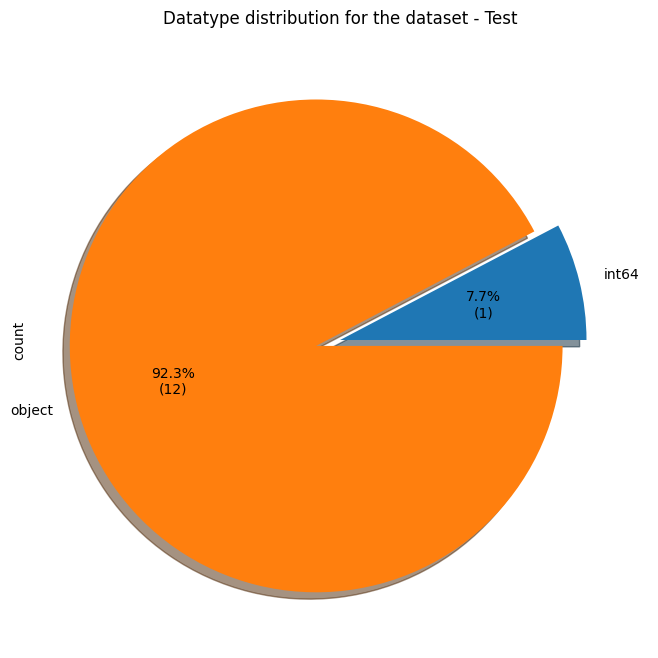

In [30]:
plot_datatype_pie_chart(cleaned_df)

<strong> Observations</strong>
> 1. Dataset for has 30,000 rows and 13 columns.
> 2. Dataset now has 1 column of datatype INT64 and the rest 12 are of type OBJECT

In [31]:
styled_null_data_aft_removing_70_percent = style_null_summary(cleaned_df)
styled_null_data_aft_removing_70_percent

Analysis on relevance of column:  <b>reviews_didPurchase</b></font>

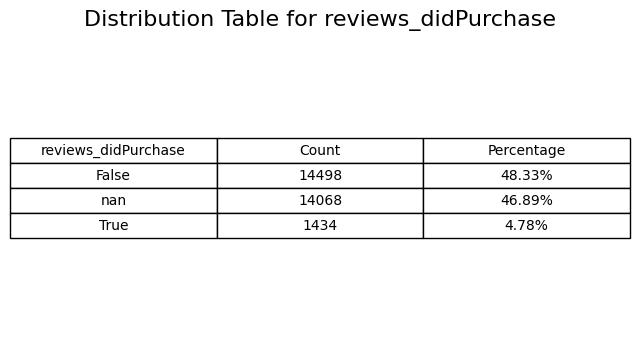

In [32]:
plot_column_distribution_table(cleaned_df,"reviews_didPurchase")

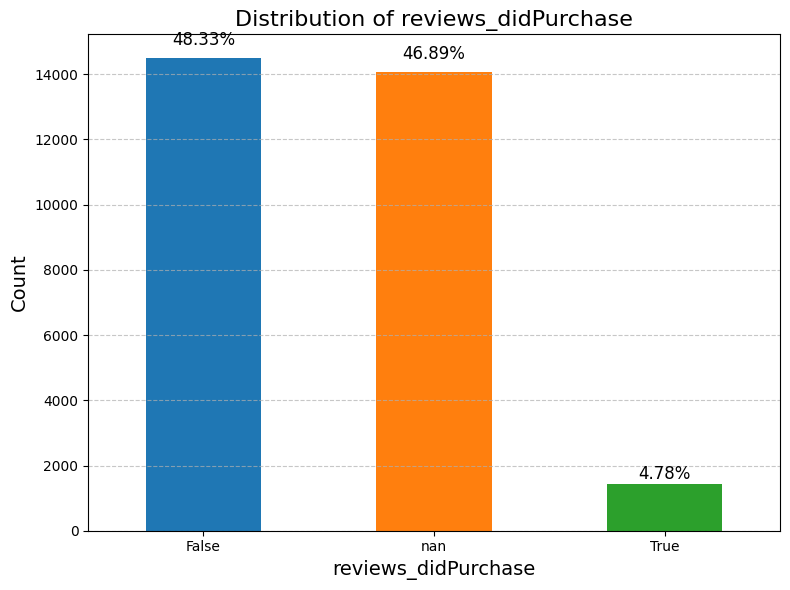

In [33]:
plot_column_distribution_graph(cleaned_df,"reviews_didPurchase")

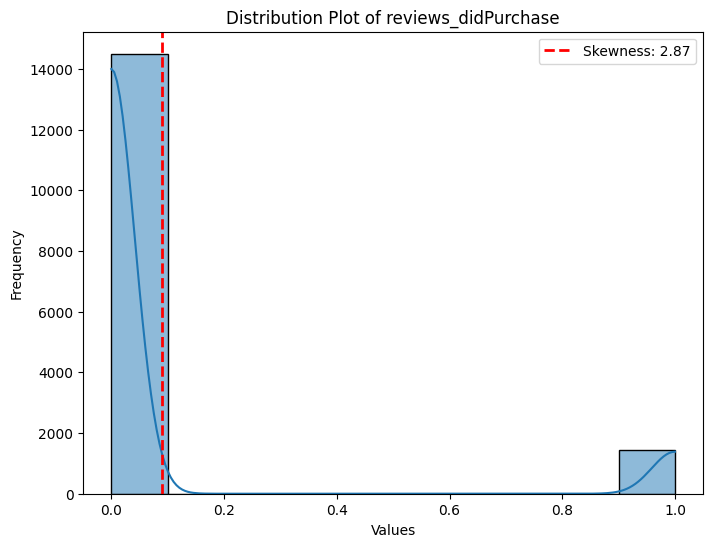

Skewness of 'reviews_didPurchase': 2.87
The column 'reviews_didPurchase' is **positively skewed** (right-skewed).


In [34]:
visualize_skewness(cleaned_df, "reviews_didPurchase")

<strong> Observations</strong>
> 1. Column "reviews_didPurchase" has 46% NULL values
> 2. Only 4% of the users who actually purchased the product dropped a review - i.e., Genenuine reviews are only 4%.
> 2. The data for "reviews_didPurchase" is negatively skewed
> 3. Due to skewness, removal of this column makes better sense than imputing. Also, imputing based the column which describes if the user purchased the product or not might lead to wrong results going forward.

Remove column: <b>reviews_didPurchase</b>

In [35]:
columns_to_drop = ['reviews_didPurchase']
cleaned_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [36]:
cleaned_df.shape

(30000, 12)

In [37]:
styled_null_data_aft_removing_reviews_didPurchase = style_null_summary(cleaned_df)
styled_null_data_aft_removing_reviews_didPurchase

 Analysis on relevance of column:  <b>reviews_doRecommend</b>

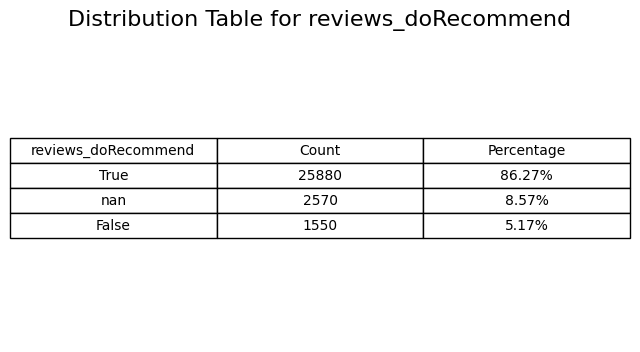

In [38]:
plot_column_distribution_table(cleaned_df,"reviews_doRecommend")

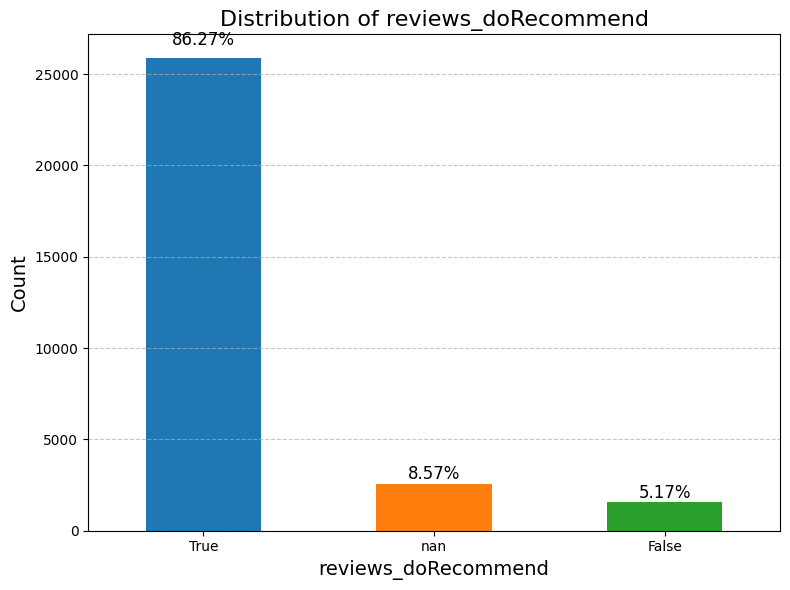

In [39]:
plot_column_distribution_graph(cleaned_df,"reviews_doRecommend")

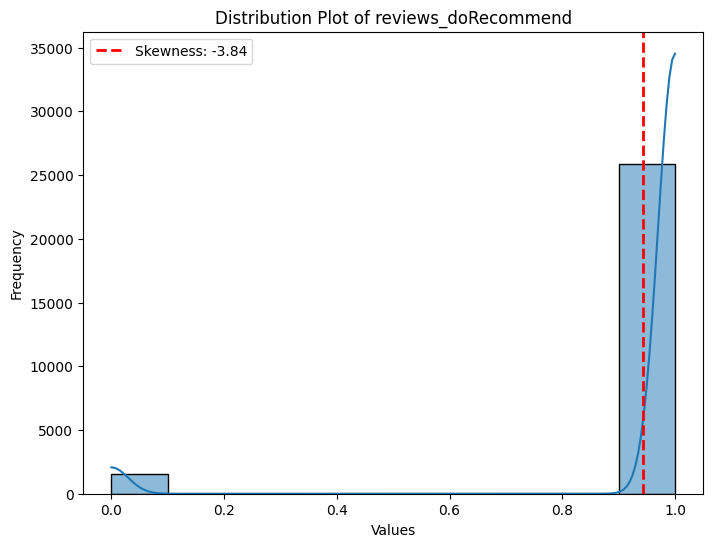

Skewness of 'reviews_doRecommend': -3.84
The column 'reviews_doRecommend' is **negatively skewed** (left-skewed).


In [40]:
visualize_skewness(cleaned_df, "reviews_doRecommend")

<strong> Observations</strong>
> 1. Column "reviews_doRecommend" has 8.5% NULL values
> 2. The data for "reviews_didPurchase" is negatively skewed
> 3. Due to skewness, removal of this column makes better sense than imputing. Also, imputing the column which describes if the user purchased the product or not might lead to wrong results going forward.
> 4. The column signifies if the user recommends the said product or not, for this decision we can depend on the "user_sentiment" column.

Remove column:  <b>reviews_doRecommend</b>

In [41]:
columns_to_drop = ['reviews_doRecommend']
cleaned_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [42]:
cleaned_df.shape

(30000, 11)

In [43]:
styled_null_data_aft_removing_reviews_doRecommend = style_null_summary(cleaned_df)
styled_null_data_aft_removing_reviews_doRecommend

Analysis on relevance of column:  <b>reviews_title</b>

<strong> Observations</strong>
> 1. Column "reviews_title" has 0.6% NULL values
> 2. The NULL value percentage is low and also imputing a column wherein the value is randomly provided by the user makes no practical sense.

<strong> Recommendations</strong>
> Replace NaN values with an empty string in the column "reviews_title"

To replace NaN values with an empty string:  <b>reviews_title</b></font>

In [44]:
cleaned_df['reviews_title'] = cleaned_df['reviews_title'].fillna('')

In [45]:
cleaned_df.shape

(30000, 11)

In [46]:
styled_null_data_aft_removing_reviews_title = style_null_summary(cleaned_df)
styled_null_data_aft_removing_reviews_title

Analysis on relevance of column:  <b>reviews_username</b></font>

<strong> Observations</strong>
> 1. Column "reviews_username" has 0.2% NULL values.
> 2. The NULL value percentage is low.

<strong> Recommendations</strong>
> Drop the column "reviews_username" from the analysis

Remove column:  <b>reviews_username</b>

In [47]:
cleaned_df['reviews_username'] = cleaned_df['reviews_username'].fillna('anonymous user')

In [48]:
cleaned_df.shape

(30000, 11)

In [49]:
styled_null_data_aft_removing_reviews_username = style_null_summary(cleaned_df)
styled_null_data_aft_removing_reviews_username

Analysis on relevance of column:  <b>user_sentiment</b>

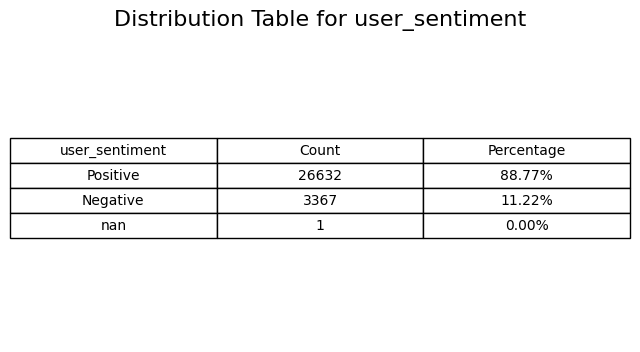

In [50]:
plot_column_distribution_table(cleaned_df,"user_sentiment")

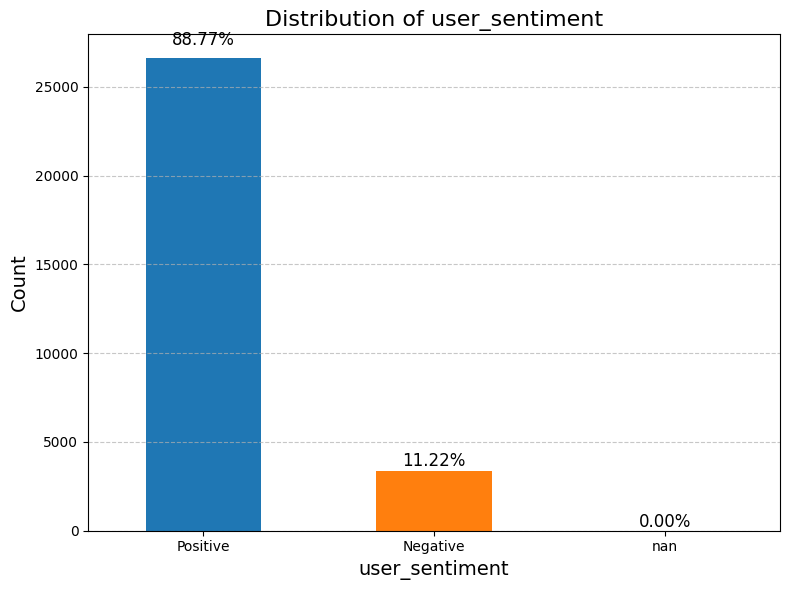

In [51]:
plot_column_distribution_graph(cleaned_df,"user_sentiment")

<strong> Observations</strong>
> 1. Column "user_sentiment" has only one NULL value
> 2. From the analysis, the overall value for "user_sentiment" is positive.

<strong> Recommendations</strong>
> Since the reviews_rating is 5, we can update the column value from "NaN" to "positive".

In [52]:
cleaned_df[cleaned_df['user_sentiment'].isna()]

id   brand  \
28354  AVpfRTh1ilAPnD_xYic2  Disney   

                                                                                                                                                                                                                                            categories  \
28354  Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys   

      manufacturer  \
28354  Walt Disney   

                                                                      name  \
28354  Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)   

                   reviews_date  reviews_rating  \
28354  2014-11-07T00:00:00.000Z               5   

                                                                                                                                                                                                                                                                                                      reviews_text  \
28354  my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the poin...   

                                         reviews_title reviews_username  \
28354  a super hit with my children. they loved it!!??         7.87E+11   

      user_sentiment  
28354            NaN

Update column:  <b>user_sentiment</b>

In [53]:
cleaned_df.user_sentiment.fillna('Positive', inplace=True)

In [54]:
cleaned_df.shape

(30000, 11)

In [55]:
styled_null_data_aft_updating_user_sentiment = style_null_summary(cleaned_df)
styled_null_data_aft_updating_user_sentiment

update the `manufacturer` column value from "NaN" to "unknown".

In [56]:
cleaned_df['manufacturer'] = cleaned_df['manufacturer'].fillna('unknown')

In [57]:
cleaned_df.head()

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                                                                                                                                       categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap   
1                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
2                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
3                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   
4                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   
3                                 K-Y   
4                                 K-Y   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)  2012-11-30T06:21:45.000Z   
1  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
2  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
3            K-Y Love Sensuality Pleasure Gel  2016-01-06T00:00:00.000Z   
4            K-Y Love Sensuality Pleasure Gel  2016-12-21T00:00:00.000Z   

   reviews_rating  \
0               5   
1               5   
2               5   
3               1   
4               1   

                                                                                                                                                                                                                                                                                                  reviews_text  \
0                                                                                                    i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.   
1                                                                                                                                                                                                                                               Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                                                                                                                 Good flavor.   
3  I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...   
4                                                                                                                                                                         My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.   

  reviews_title reviews_username user_sentiment  
0  Just Awesome           joshua       Positive  
1  

In [58]:
cleaned_df.shape

(30000, 11)

## <font color = orange> <strong> <center> <u> DATA CLEANING: Check User sentiment and user rating mapping</u> </center> </strong> </font>



In [59]:
cleaned_df["user_sentiment"].value_counts()

user_sentiment
Positive    26633
Negative     3367
Name: count, dtype: int64

In [60]:
cleaned_df[(cleaned_df["user_sentiment"]=="Positive") & (cleaned_df["reviews_rating"]<4)][["reviews_title","reviews_text", "reviews_rating"]]

reviews_title  \
9                       Don't buy   
11                 Waste of Money   
14                   Disappointed   
18                    Pretty nice   
54        New formula is terrible   
...                           ...   
29050  Didn't Do Much For Dryness   
29051                Not the best   
29053           clay conditioning   
29054                          Eh   
29055                   Just Okay   

                                                                                                                                                                                                                                                                                                      reviews_text  \
9                                                                                                                                       Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund   
11                                                                                                                                                                                    Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.   
14                                                                                                                                    First time purchase of this type of product. Maybe I expected too much. Did not think there was any warming feeling at all. Left us sticky! Even after trying to was it off.   
18                                                                                 I bought this because it had better reviews than the his and hers jelly, but I feel like it didn't work that well for us. It was kind of warm-feeling, but that's about it. I guess I don't know what's supposed to happen! Lol   
54                                          I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product.   
...                                                                                                                                                                                                                                                                                                            ...   
29050  I received this product from Influenster. I absolutely love the whole system together, it made my hair oil-free for 48 hours. But I expected the conditioner to do more for the dryness at the ends of my hair like advertised. I didn't really notice much of a different in dryness before and after I...   
29051  I used this product for a month straight before reviewing it and I'm not really all that impressed. My hair still gets pretty oily, my ends are still dry.... I mean it cleaned my hair I guess. It's nothing spectacular really. It didn't make my hair extremely soft but it didn't make my hair feel ...   
29053                                                                                                                                              Got this item as a compliment from influenster but it really made my hair smooth and shining after the usage. This review was collected as part of a promotion.   
29054  I am not in love with the conditioner. The clay mask and shampoo are GREAT but I didn't feel like this did anything for my ends. I would buy the other two, but not this, probably because I have fine hair and my ends need deep conditioning. Smells great though! I got this product free for testing...   
29055  This conditioner didn't wow me as much as the mask and shampoo of the line did. The conditioner wasn't of a very thick consistency, which I prefer for conditi

In [61]:
cleaned_df[(cleaned_df["user_sentiment"]=="Negative") & (cleaned_df["reviews_rating"]>=4)][["reviews_title","reviews_text", "reviews_rating"]]

reviews_title  \
92                            hydrating but not too heavy   
96     This product has made a real difference on my skin   
100               Noticed a difference in just two weeks!   
106                                       Very rich cream   
117                                            Not greasy   
...                                                   ...   
29818                                       Great Product   
29855                                               Great   
29858    Makes my hair soft and shiny without excess oil!   
29862                                   Great Conditioner   
29941     Good for keeping combination hair under control   

                                                                                                                                                                                                                                                                                                      reviews_text  \
92                                                                                                                                                                                          It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.   
96                                                                                                                                                                                                In only a week I can see the difference in my skin on my face. This review was collected as part of a promotion.   
100                                                                                                                                               This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. This review was collected as part of a promotion.   
106                                                                                                               I like to use this cream on my neck and collarbone to help keep my skin well moisturized, but it can be a little heavy for the skin on my face This review was collected as part of a promotion.   
117                                                     I finally found a moisturizing product that will absorb completely and not leave my skin feeling like it's suffocating. I apply it, and it feels like there is nothing there but my skin looks smoother. This review was collected as part of a promotion.   
...                                                                                                                                                                                                                                                                                                            ...   
29818  I received a complimentary sample of this product and it worked so well for my hair! I have very thick hair so my roots always get oily and my ends are dry, this left my hair the cleanest it's felt in a long time. Will def recommend this to my family and friends! This review was collected as par...   
29855                                                                                                                                     This has prolonged the color in my hair! Not only is my hair healthier but I think I'll have to visit my stylist less! This review was collected as part of a promotion.   
29858  This conditioner makes my hair very soft without weighing it down! I was afraid it'd make my roots more oily and weight them down, but it doesn't one bit! My hair is colored, and it hasn't faded out the color either! I'd highly recommend giving this a try! This review was collected as part of a ...   
29862                                                                                                                                                                                                    This condi

In [62]:
cleaned_df.loc[(cleaned_df["user_sentiment"]=="Positive") & (cleaned_df["reviews_rating"]<4), "user_sentiment"] = "Negative"
cleaned_df.loc[(cleaned_df["user_sentiment"]=="Negative") & (cleaned_df["reviews_rating"]>=4), "user_sentiment"] = "Positive"

In [63]:
cleaned_df["user_sentiment"].value_counts()

user_sentiment
Positive    26851
Negative     3149
Name: count, dtype: int64

## <font color = orange> <strong> <center> <u> DATA CLEANING: Type Conversion </u> </center> </strong> </font>

Analyse and assign appropriate data-type to columns </font>

In [64]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                30000 non-null  object
 1   brand             30000 non-null  object
 2   categories        30000 non-null  object
 3   manufacturer      30000 non-null  object
 4   name              30000 non-null  object
 5   reviews_date      29954 non-null  object
 6   reviews_rating    30000 non-null  int64 
 7   reviews_text      30000 non-null  object
 8   reviews_title     30000 non-null  object
 9   reviews_username  30000 non-null  object
 10  user_sentiment    30000 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.5+ MB


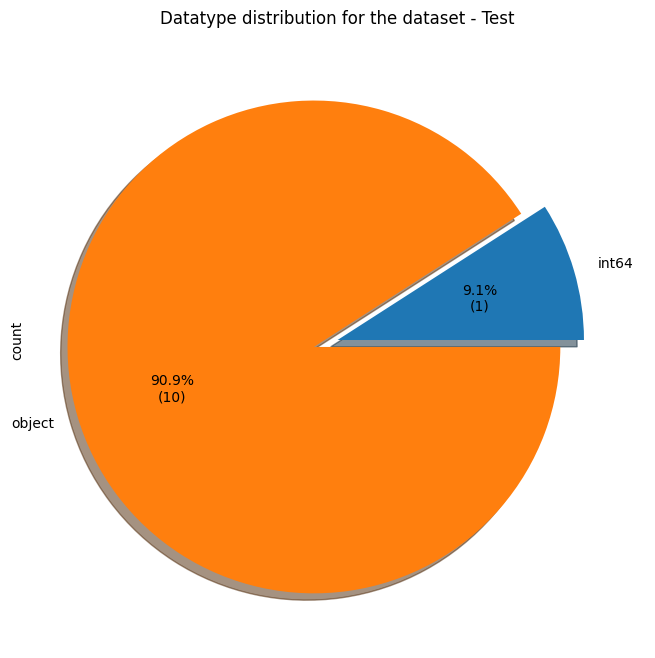

In [65]:
plot_datatype_pie_chart(cleaned_df)

In [66]:
cleaned_df["id"] = cleaned_df["id"].astype(str)
cleaned_df["brand"] = cleaned_df["brand"].astype(str)
cleaned_df["categories"] = cleaned_df["categories"].astype(str)
cleaned_df["manufacturer"] = cleaned_df["manufacturer"].astype(str)
cleaned_df["name"] = cleaned_df["name"].astype(str)
cleaned_df['reviews_date'] = pd.to_datetime(cleaned_df['reviews_date'], errors='coerce')
cleaned_df["reviews_text"] = cleaned_df["reviews_text"].astype(str)
cleaned_df["reviews_title"] = cleaned_df["reviews_title"].astype(str)
cleaned_df["reviews_username"] = cleaned_df["reviews_username"].astype(str)
cleaned_df["user_sentiment"] = cleaned_df["user_sentiment"].astype('category')

In [67]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                30000 non-null  object             
 1   brand             30000 non-null  object             
 2   categories        30000 non-null  object             
 3   manufacturer      30000 non-null  object             
 4   name              30000 non-null  object             
 5   reviews_date      29255 non-null  datetime64[ns, UTC]
 6   reviews_rating    30000 non-null  int64              
 7   reviews_text      30000 non-null  object             
 8   reviews_title     30000 non-null  object             
 9   reviews_username  30000 non-null  object             
 10  user_sentiment    30000 non-null  category           
dtypes: category(1), datetime64[ns, UTC](1), int64(1), object(8)
memory usage: 2.3+ MB


In [68]:
unique_value_counts(cleaned_df)

Column  Unique Count
0                 id           271
1              brand           214
2         categories           270
3       manufacturer           228
4               name           271
5       reviews_date          6277
6     reviews_rating             5
7       reviews_text         27282
8      reviews_title         18536
9   reviews_username         24915
10    user_sentiment             2

## <font color = orange> <strong> <center> <u> DATA EXPLORATION: Exploratory Data Analysis </u> </center> </strong> </font>

In [69]:
display_first_last_unique(cleaned_df,["id", "brand", "manufacturer", "reviews_username"])

In [70]:
cleaned_df.head()

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                                                                                                                                       categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap   
1                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
2                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
3                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   
4                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   
3                                 K-Y   
4                                 K-Y   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd) 2012-11-30 06:21:45+00:00   
1  Lundberg Organic Cinnamon Toast Rice Cakes 2017-07-09 00:00:00+00:00   
2  Lundberg Organic Cinnamon Toast Rice Cakes 2017-07-09 00:00:00+00:00   
3            K-Y Love Sensuality Pleasure Gel 2016-01-06 00:00:00+00:00   
4            K-Y Love Sensuality Pleasure Gel 2016-12-21 00:00:00+00:00   

   reviews_rating  \
0               5   
1               5   
2               5   
3               1   
4               1   

                                                                                                                                                                                                                                                                                                  reviews_text  \
0                                                                                                    i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.   
1                                                                                                                                                                                                                                               Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                                                                                                                 Good flavor.   
3  I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...   
4                                                                                                                                                                         My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.   

  reviews_title reviews_username user_sentiment  
0  Just Awesome           joshua       Positive  
1  

### <span style='color:blue;'>First 5 rows of the data:</span>

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                                                                                                                                       categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap   
1                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
2                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
3                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   
4                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   
3                                 K-Y   
4                                 K-Y   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd) 2012-11-30 06:21:45+00:00   
1  Lundberg Organic Cinnamon Toast Rice Cakes 2017-07-09 00:00:00+00:00   
2  Lundberg Organic Cinnamon Toast Rice Cakes 2017-07-09 00:00:00+00:00   
3            K-Y Love Sensuality Pleasure Gel 2016-01-06 00:00:00+00:00   
4            K-Y Love Sensuality Pleasure Gel 2016-12-21 00:00:00+00:00   

   reviews_rating  \
0               5   
1               5   
2               5   
3               1   
4               1   

                                                                                                                                                                                                                                                                                                  reviews_text  \
0                                                                                                    i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.   
1                                                                                                                                                                                                                                               Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                                                                                                                 Good flavor.   
3  I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...   
4                                                                                                                                                                         My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.   

  reviews_title reviews_username user_sentiment  
0  Just Awesome           joshua       Positive  
1  

### <span style='color:green;'>Summary statistics for numeric columns:</span>

reviews_rating
count        30000.00
mean             4.48
std              0.99
min              1.00
25%              4.00
50%              5.00
75%              5.00
max              5.00

### <span style='color:orange;'>Missing values in each numeric column:</span>

reviews_rating    0
dtype: int64

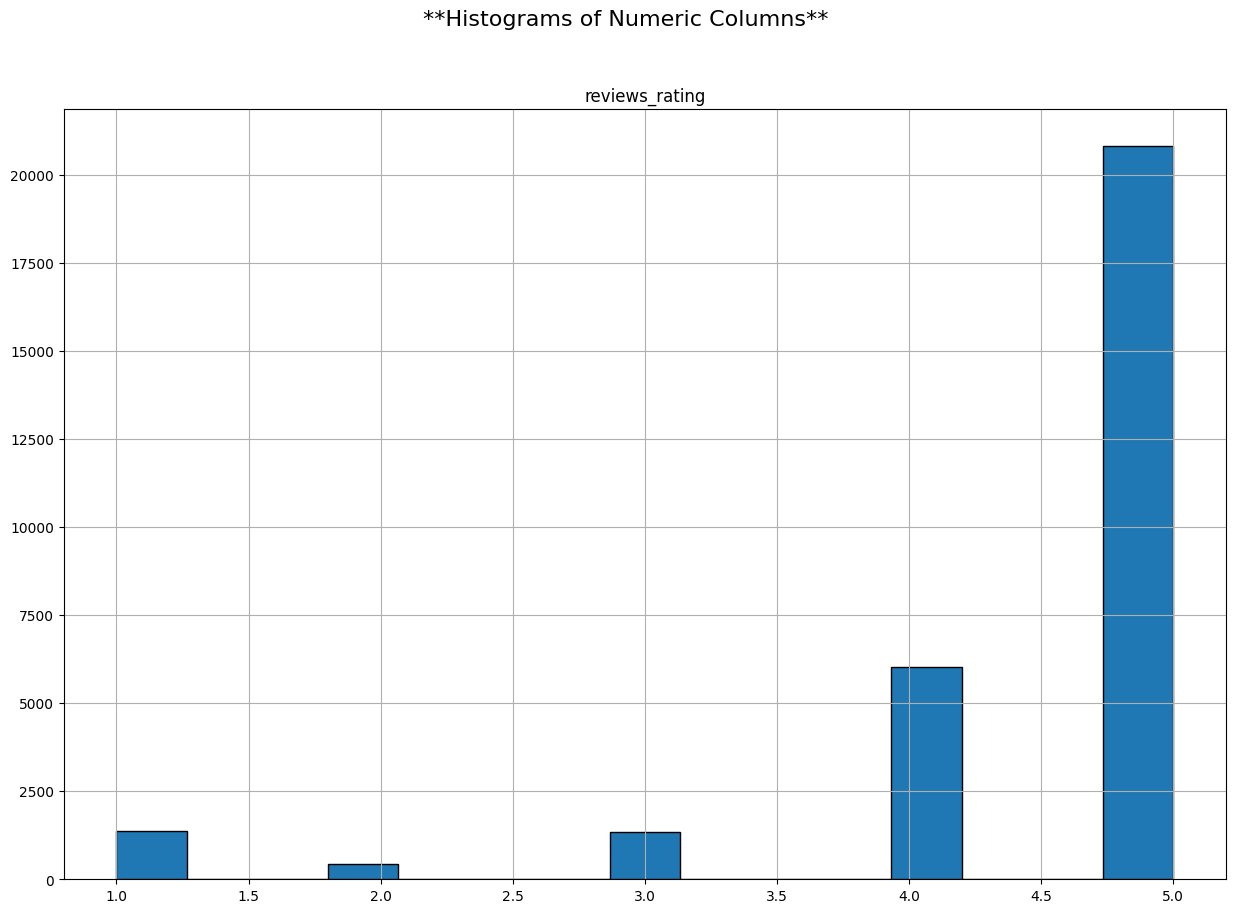

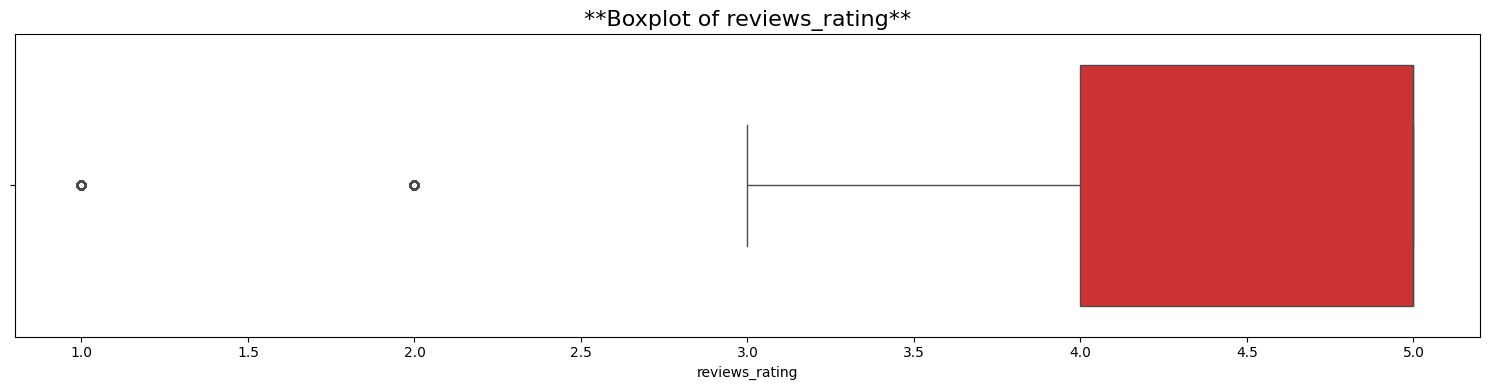

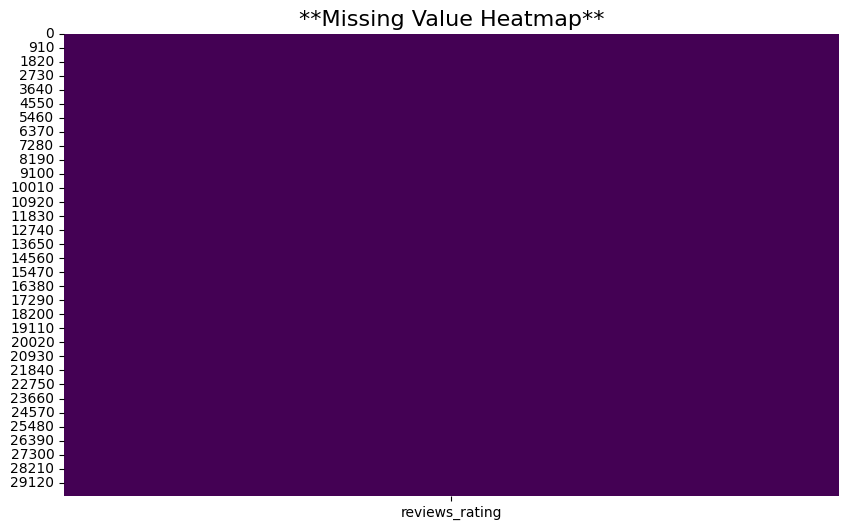

In [71]:
exploratory_data_analysis(cleaned_df)

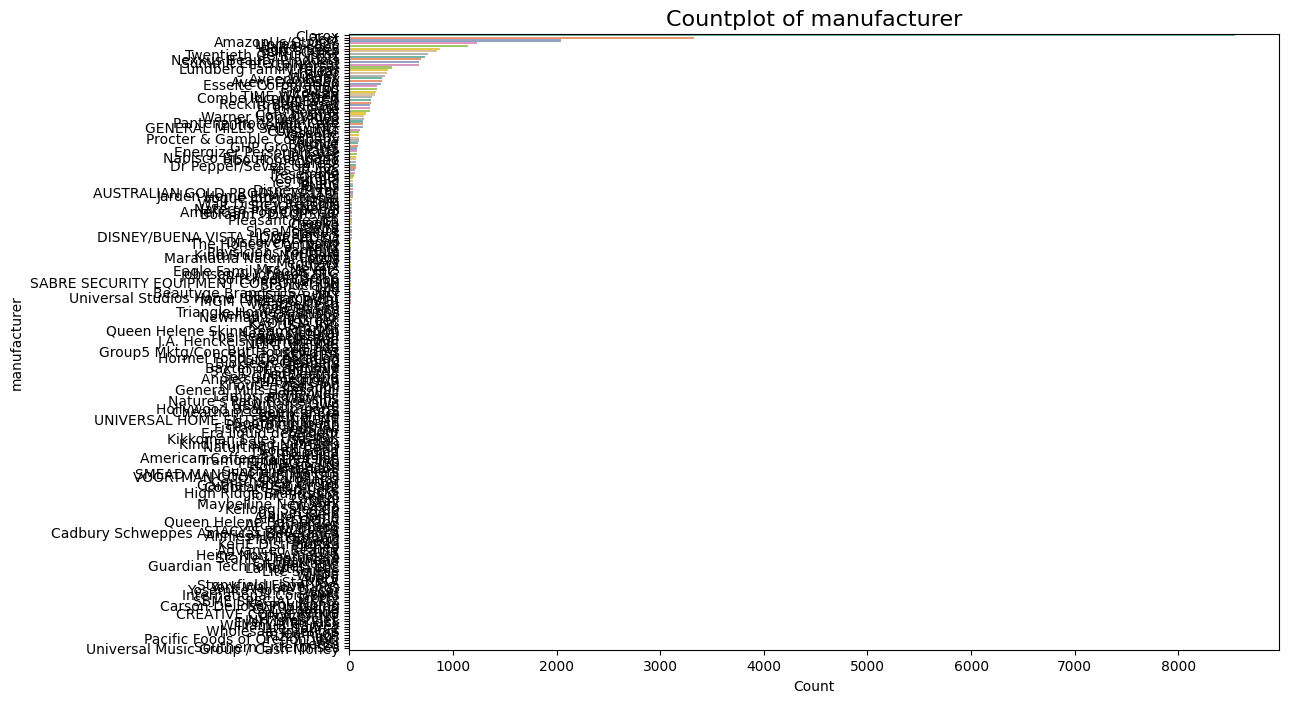

### Value counts for 'manufacturer':

manufacturer
Clorox                                8546
Test                                  3325
AmazonUs/CLOO7                        2039
L'oreal Paris                         1232
Walt Disney                           1143
                                      ... 
Pacific Foods of Oregon, Inc.            1
Unfi                                     1
Herr's                                   1
Southern Enterprises                     1
Universal Music Group / Cash Money       1
Name: count, Length: 228, dtype: int64

In [72]:
visualize_non_numeric_column(cleaned_df, "manufacturer")

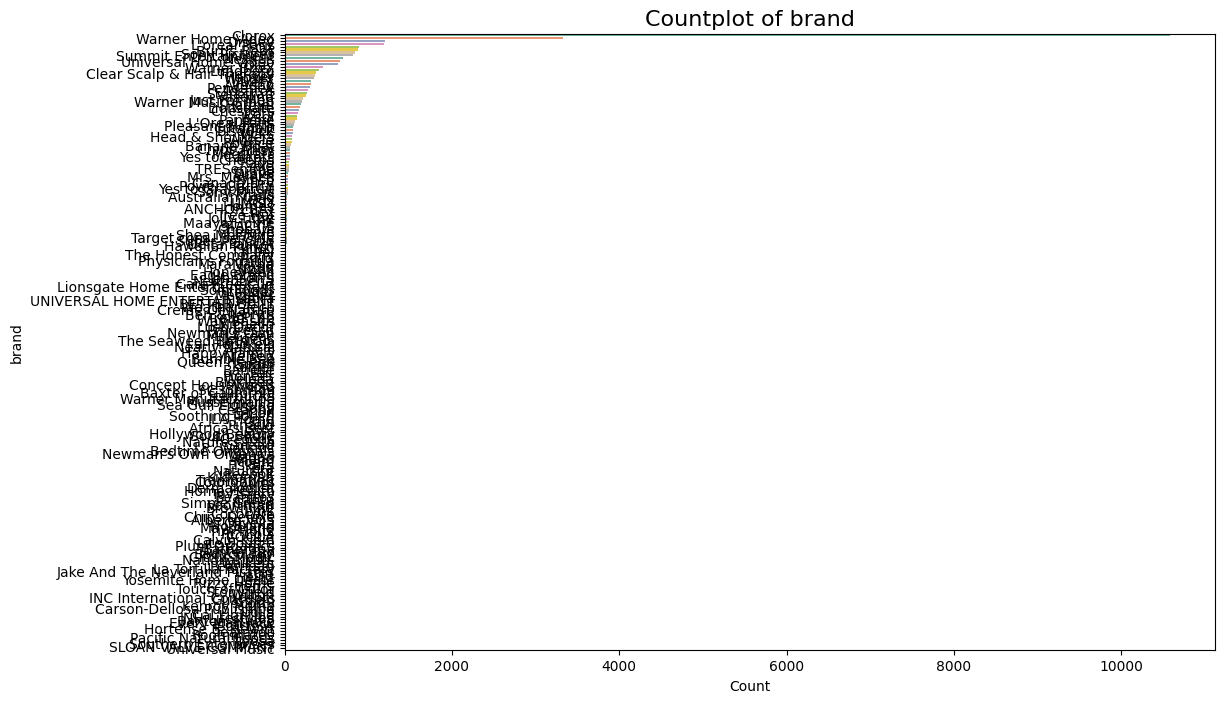

### Value counts for 'brand':

brand
Clorox                   10585
Warner Home Video         3325
Disney                    1200
L'oreal Paris             1186
FOX                        887
                         ...  
Pacific Natural Foods        1
Noosa                        1
Southern Enterprises         1
SLOAN VALVE COMPANY          1
Universal Music              1
Name: count, Length: 214, dtype: int64

In [73]:
visualize_non_numeric_column(cleaned_df, "brand")

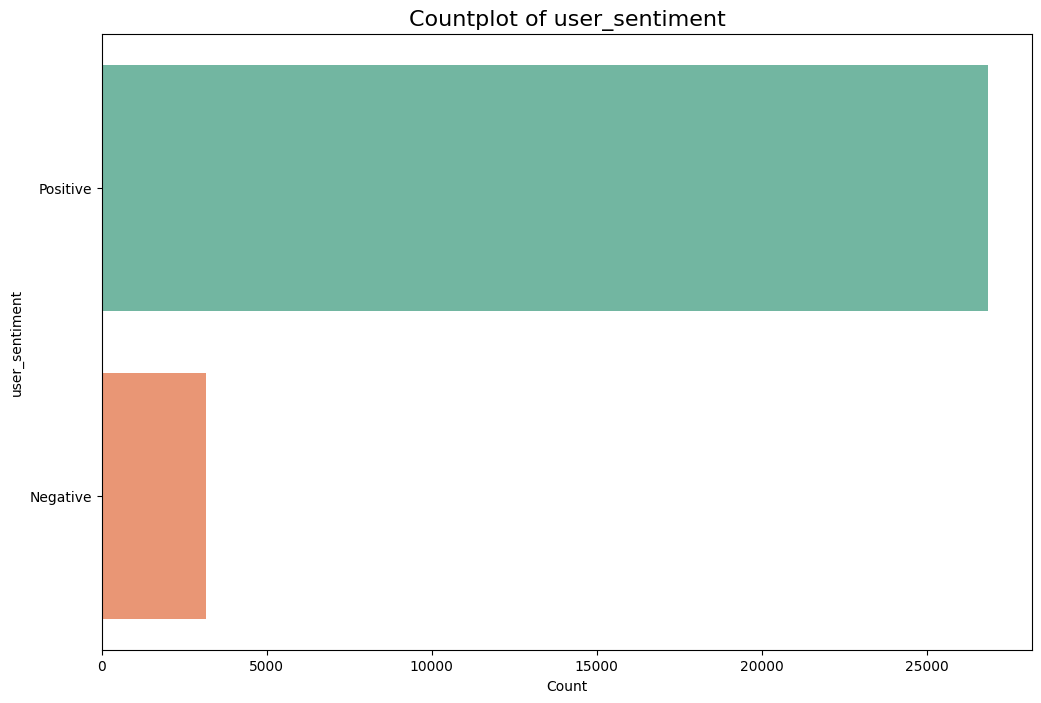

### Value counts for 'user_sentiment':

user_sentiment
Positive    26851
Negative     3149
Name: count, dtype: int64

In [74]:
visualize_non_numeric_column(cleaned_df, "user_sentiment")

Data Distribution:  <b>reviews_rating</b>

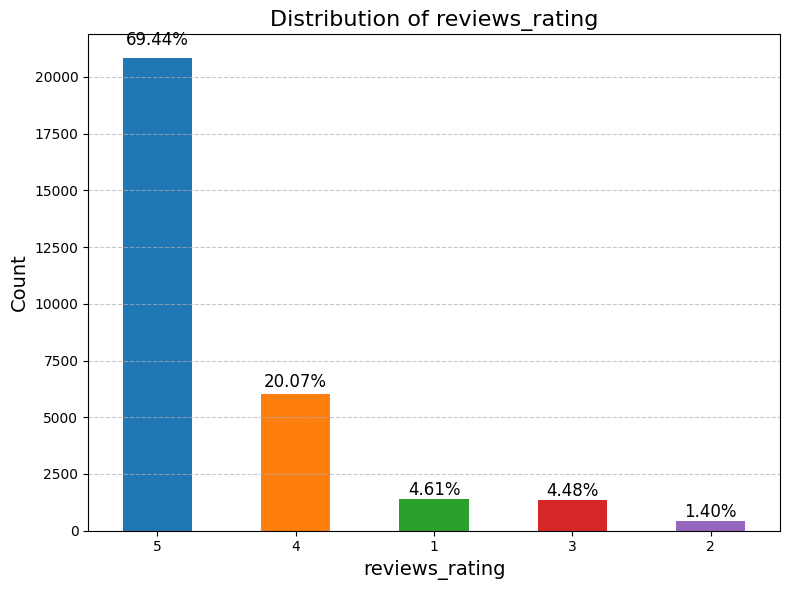

In [75]:
plot_column_distribution_graph(cleaned_df, "reviews_rating")

<strong> Observations</strong>
> 1. Column "reviews_rating" has majority reviews with rating 5.

Data Distribution:  <b>Top 5 brands with positive reviews</b>

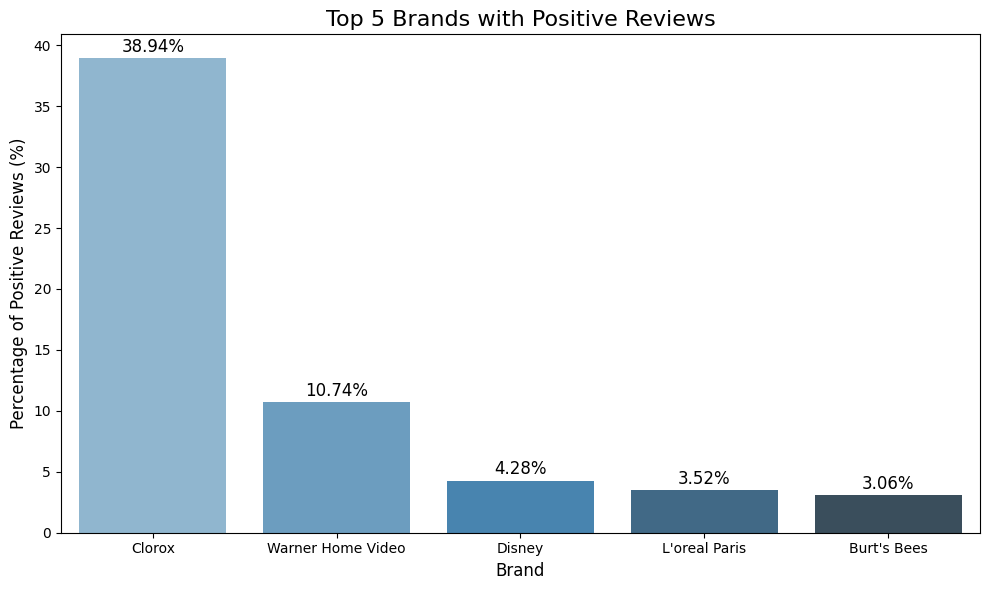

In [76]:
positive_brands = cleaned_df[cleaned_df["user_sentiment"] == 'Positive']["brand"]
top_brands = positive_brands.value_counts(normalize=True, ascending=False).head(5) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_brands.index, y=top_brands.values, palette="Blues_d")

# Add title and labels
plt.title(f"Top 5 Brands with Positive Reviews", fontsize=16)
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Percentage of Positive Reviews (%)", fontsize=12)

# Display percentage values on top of each bar
for i, value in enumerate(top_brands.values):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center', fontsize=12)

# Improve layout and display the plot
plt.tight_layout()
plt.show()

<strong> Observations</strong>
> 1. With 36.30% positive reviews, brand "Clorox" has the most positive reviews in the dataset.

Data Distribution:  <b>Top 5 brands with negative reviews</b>

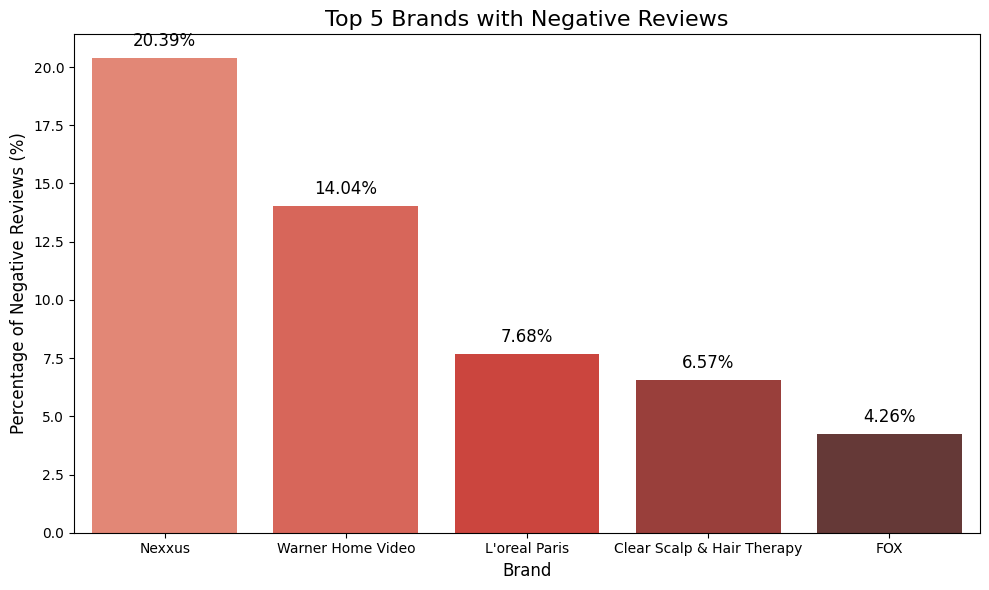

In [77]:
# Filter negative sentiment brands
negative_brands = cleaned_df[cleaned_df["user_sentiment"] == 'Negative']["brand"]
top_brands = negative_brands.value_counts(normalize=True, ascending=False).head(5) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_brands.index, y=top_brands.values, palette="Reds_d")

# Add title and labels
plt.title(f"Top 5 Brands with Negative Reviews", fontsize=16)
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Percentage of Negative Reviews (%)", fontsize=12)

# Display percentage values on top of each bar
for i, value in enumerate(top_brands.values):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center', fontsize=12)

# Improve layout and display the plot
plt.tight_layout()
plt.show()

<strong> Observations</strong>
> 1. With 29.27% negative reviews, brand "Clorox" has the most negative reviews in the dataset.

> 2. "Clorox" is the brand with the highest positive as well as negative reviews because the dataset has 35.51% of the data coming from the brand "Clorox"

Data Distribution:  <b>Review count linked to Review Year</b>

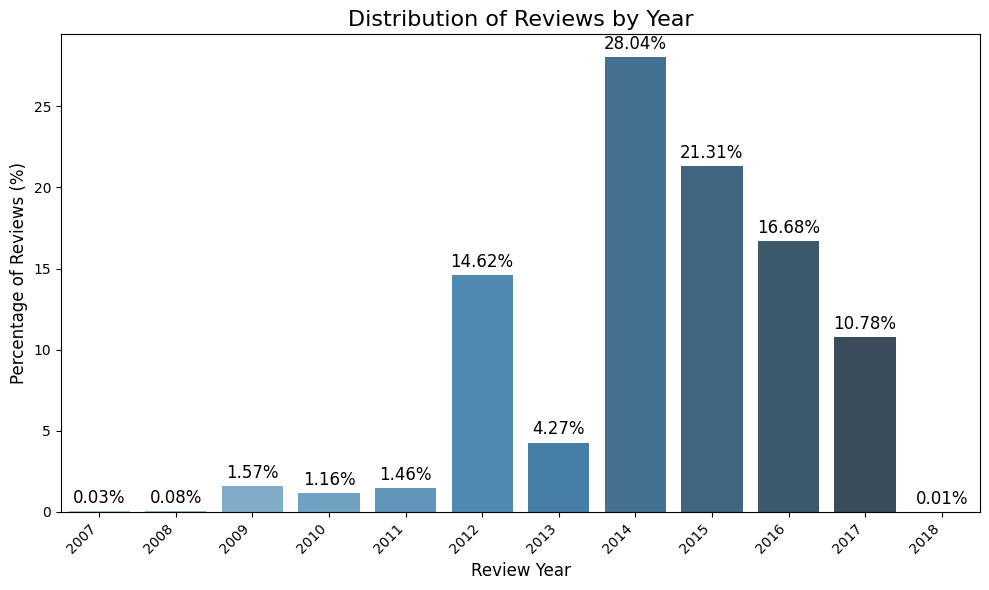

In [78]:
# Group the date column by the specified frequency (e.g., by year)
date_counts = cleaned_df["reviews_date"].dt.to_period("Y").value_counts().sort_index()

# Calculate the percentage of each count
total_reviews = date_counts.sum()
percentage_counts = (date_counts / total_reviews) * 100

# Plot the date distribution
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=date_counts.index.astype(str), y=percentage_counts.values, palette="Blues_d")

# Add plot title and labels
plt.title(f"Distribution of Reviews by Year", fontsize=16)
plt.xlabel(f"Review Year", fontsize=12)
plt.ylabel("Percentage of Reviews (%)", fontsize=12)

# Display percentage values on top of each bar
for i, value in enumerate(percentage_counts.values):
    bar_plot.text(i, value + 0.5, f'{value:.2f}%', ha='center', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Improve layout and display the plot
plt.tight_layout()
plt.show()


<strong> Observations</strong>
> 1. Within the dataset, most of the reviews were provided in the year 2014 - 28.03% of the total count.

Data Distribution:  <b>Review count linked to User Sentiment</b>

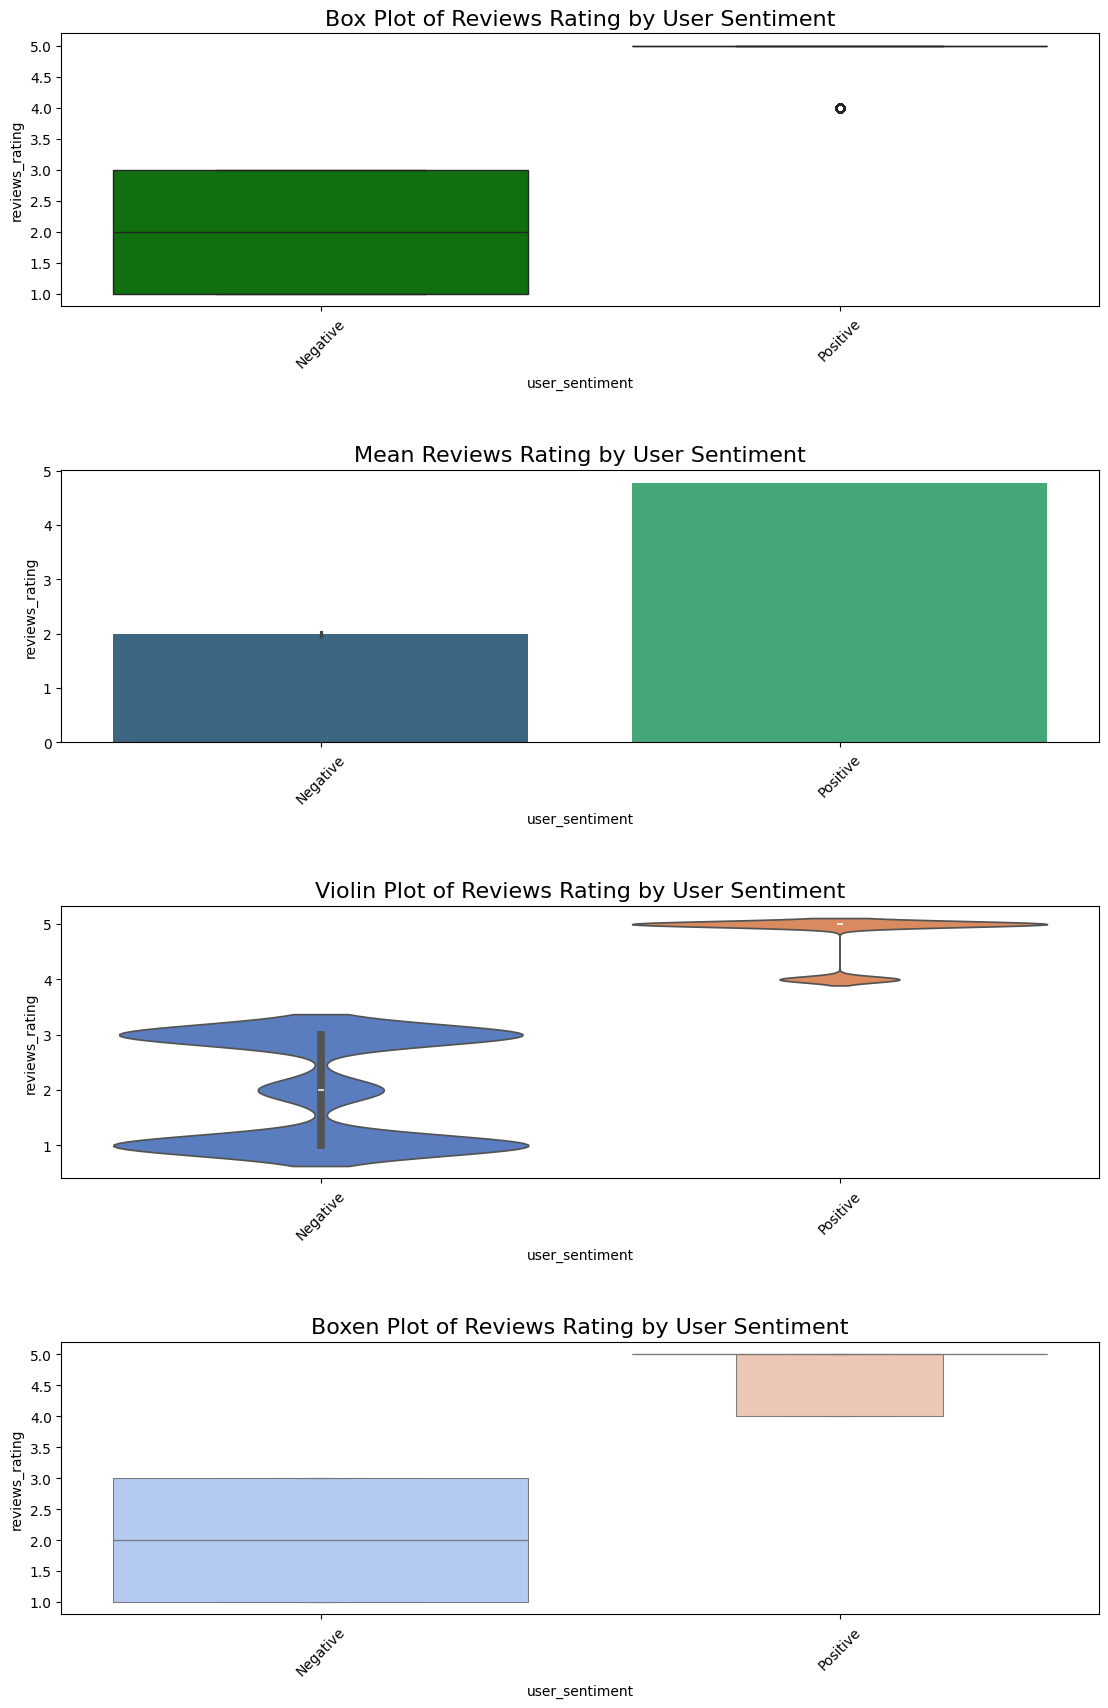

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the figure size and layout
plt.figure(figsize=(12, 18))

# Box Plot
plt.subplot(4, 1, 1)
sns.boxplot(data=cleaned_df, x='user_sentiment', y='reviews_rating', color='green')
plt.title('Box Plot of Reviews Rating by User Sentiment', fontsize=16)
plt.xticks(rotation=45)

# Bar Plot
plt.subplot(4, 1, 2)
sns.barplot(data=cleaned_df, x='user_sentiment', y='reviews_rating', estimator=np.mean, palette='viridis')
plt.title('Mean Reviews Rating by User Sentiment', fontsize=16)
plt.xticks(rotation=45)

# Violin Plot
plt.subplot(4, 1, 3)
sns.violinplot(data=cleaned_df, x='user_sentiment', y='reviews_rating', palette='muted')
plt.title('Violin Plot of Reviews Rating by User Sentiment', fontsize=16)
plt.xticks(rotation=45)

# Boxen Plot
plt.subplot(4, 1, 4)
sns.boxenplot(data=cleaned_df, x='user_sentiment', y='reviews_rating', palette='coolwarm')
plt.title('Boxen Plot of Reviews Rating by User Sentiment', fontsize=16)
plt.xticks(rotation=45)

# Adjust layout and display the plots
plt.tight_layout(pad=4)
plt.show()


<strong> Observations</strong>
> 1. Reviews v/s User-Sentiment plot leads to observation where in even if the user sentiment is negative there are positive reviews and vice-versa. This is indeed a contradicting detail.

## <font color = orange> <strong> <center> <u> FEATURE ENGINEERING: Form new fields from the existing data </u> </center> </strong> </font>

In [80]:
df_before_feature_eng = cleaned_df.copy()

In [81]:
df_after_feature_eng = cleaned_df.copy()

New REVIEW column: Combine reviews-title and reviews-text columns to form a single column</b>

In [82]:
df_after_feature_eng['reviews'] = df_after_feature_eng[["reviews_title", "reviews_text"]].agg(lambda x: ' | '.join(x), axis=1)

In [83]:
df_after_feature_eng.head()

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                                                                                                                                       categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap   
1                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
2                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
3                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   
4                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   
3                                 K-Y   
4                                 K-Y   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd) 2012-11-30 06:21:45+00:00   
1  Lundberg Organic Cinnamon Toast Rice Cakes 2017-07-09 00:00:00+00:00   
2  Lundberg Organic Cinnamon Toast Rice Cakes 2017-07-09 00:00:00+00:00   
3            K-Y Love Sensuality Pleasure Gel 2016-01-06 00:00:00+00:00   
4            K-Y Love Sensuality Pleasure Gel 2016-12-21 00:00:00+00:00   

   reviews_rating  \
0               5   
1               5   
2               5   
3               1   
4               1   

                                                                                                                                                                                                                                                                                                  reviews_text  \
0                                                                                                    i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.   
1                                                                                                                                                                                                                                               Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                                                                                                                 Good flavor.   
3  I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...   
4                                                                                                                                                                         My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.   

  reviews_title reviews_username user_sentiment  \
0  Just Awesome           joshua       Positive   
1

Delete columns: Delete "reviews_title" and "reviews_text" columns </b>

In [84]:
df_after_feature_eng = df_after_feature_eng.drop(columns=['reviews_title', 'reviews_text'])

In [85]:
df_after_feature_eng.head()

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                                                                                                                                       categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap   
1                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
2                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
3                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   
4                                                                           Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   
3                                 K-Y   
4                                 K-Y   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd) 2012-11-30 06:21:45+00:00   
1  Lundberg Organic Cinnamon Toast Rice Cakes 2017-07-09 00:00:00+00:00   
2  Lundberg Organic Cinnamon Toast Rice Cakes 2017-07-09 00:00:00+00:00   
3            K-Y Love Sensuality Pleasure Gel 2016-01-06 00:00:00+00:00   
4            K-Y Love Sensuality Pleasure Gel 2016-12-21 00:00:00+00:00   

   reviews_rating reviews_username user_sentiment  \
0               5           joshua       Positive   
1               5        dorothy w       Positive   
2               5        dorothy w       Positive   
3               1          rebecca       Negative   
4               1        walker557       Negative   

                                                                                                                                                                                                                                                                                                       reviews  
0                                                                                     Just Awesome | i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.  
1                                                                                                                                                                                                                                        Good | Good flavor. This review was collected as part of a promotion.  
2                                                                                                                                                                                                                                                                                          Good | Good flavor.  
3  Disappointed | I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensatio...  
4                                                                                                                                                            Irritation | My husband bought this gel for us. The gel caused irr

## <font color = orange> <strong> <center> <u> PRE-PROCESSING: Dataframe for sentiment analysis </u> </center> </strong> </font>

Make dataframe copies: Before and After pre-processing stage

In [86]:
df_before_pre_process = df_after_feature_eng.copy()
df_after_pre_process = df_after_feature_eng.copy()

### Clean-Up: Retain only column necessary for sentiment analysis </b>

Considering only the below columns:
    * "id",
    * "name"
    * "reviews_combined" and
    * "user_sentiment"

In [87]:
df_after_pre_process = df_after_pre_process[['id','name','reviews', 'user_sentiment']]

In [88]:
df_after_pre_process.shape

(30000, 4)

In [89]:
df_after_pre_process.head()

id                                        name  \
0  AV13O1A8GV-KLJ3akUyj   Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
2  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
3  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   
4  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   

                                                                                                                                                                                                                                                                                                       reviews  \
0                                                                                     Just Awesome | i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.   
1                                                                                                                                                                                                                                        Good | Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                                                                                                          Good | Good flavor.   
3  Disappointed | I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensatio...   
4                                                                                                                                                            Irritation | My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.   

  user_sentiment  
0       Positive  
1       Positive  
2       Positive  
3       Negative  
4       Negative

### Data Handling: Remove Puntuations </b>

In [90]:
df_after_pre_process["reviews_cleaned"] = df_after_pre_process["reviews"].apply(clean_punctuation)

In [91]:
df_after_pre_process.head()

id                                        name  \
0  AV13O1A8GV-KLJ3akUyj   Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
2  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
3  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   
4  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   

                                                                                                                                                                                                                                                                                                       reviews  \
0                                                                                     Just Awesome | i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.   
1                                                                                                                                                                                                                                        Good | Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                                                                                                          Good | Good flavor.   
3  Disappointed | I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensatio...   
4                                                                                                                                                            Irritation | My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.   

  user_sentiment  \
0       Positive   
1       Positive   
2       Positive   
3       Negative   
4       Negative   

                                                                                                                                                                                                                                                                                               reviews_cleaned  
0                                                                                               just awesome  i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it 5star rating all the way her metaphors are just crazy  
1                                                                                                                                                                                                                                           good  good flavor this review was collected as part of a promotion  
2                                                                                                                                                                                                                                                                                            good  good flavor  
3  disappointed  i read through the reviews on here before looking in to buying one of the couples lubricants and was ultimately disappointed that it didnt even live up to the reviews i had read for starters neither my boyfriend nor i could notice any sort of enhanced or captivating sensation what ...  
4                                                                                                              

### Data Handling: Remove Stopwords </b>

In [92]:
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words("english"))
print(stopwords_set)

{'being', 'mightn', 'all', 'don', 'he', 'hers', 'ourselves', 'll', "shan't", 'after', 's', 'how', 'did', 'it', 'such', 'yours', 'again', 'having', "mightn't", 'yourselves', 'out', 'when', 'down', "wasn't", 'didn', "wouldn't", 'was', 'with', 'during', 'through', 'mustn', 'd', 'haven', "isn't", 'on', "should've", 'we', 'couldn', 'into', 'just', "haven't", "won't", "shouldn't", 'under', 'has', 'whom', "you'll", "hadn't", 'from', 'me', 'an', 'hadn', 'this', "she's", 'her', 'am', 'can', "weren't", "you'd", 'more', "you're", 'shan', 'in', 'hasn', 'm', "mustn't", 'won', 'between', "needn't", "didn't", 'above', 'or', 'once', 'of', 'wasn', 't', 'wouldn', 'same', 'our', 'now', 'its', 'any', 'for', "aren't", 'are', 'herself', 'before', 'by', 'o', 'until', 'which', 'each', 'most', 'shouldn', 'my', 'theirs', 'too', 'aren', 'you', 'them', 'been', 'about', 're', 'ma', "you've", 'that', 'why', 'what', 'itself', 'both', 'so', 'a', 'then', 'as', 'there', 'than', "it's", 'his', 'other', 'they', 'while', 

In [93]:
nltk.download('punkt_tab')
df_after_pre_process['reviews_stopwords'] = df_after_pre_process['reviews_cleaned'].apply(clean_stopwords)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [94]:
df_after_pre_process.head()

id                                        name  \
0  AV13O1A8GV-KLJ3akUyj   Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
2  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
3  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   
4  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   

                                                                                                                                                                                                                                                                                                       reviews  \
0                                                                                     Just Awesome | i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.   
1                                                                                                                                                                                                                                        Good | Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                                                                                                          Good | Good flavor.   
3  Disappointed | I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensatio...   
4                                                                                                                                                            Irritation | My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.   

  user_sentiment  \
0       Positive   
1       Positive   
2       Positive   
3       Negative   
4       Negative   

                                                                                                                                                                                                                                                                                               reviews_cleaned  \
0                                                                                               just awesome  i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it 5star rating all the way her metaphors are just crazy   
1                                                                                                                                                                                                                                           good  good flavor this review was collected as part of a promotion   
2                                                                                                                                                                                                                                                                                            good  good flavor   
3  disappointed  i read through the reviews on here before looking in to buying one of the couples lubricants and was ultimately disappointed that it didnt even live up to the reviews i had read for starters neither my boyfriend nor i could notice any sort of enhanced or captivating sensation what ...   
4                                                                                                         

### Data Handling: Perform Lemmatization </b>

In [95]:
from tqdm import tqdm

# Enable tqdm for pandas apply
tqdm.pandas()

# Apply the clean_lemma function with a progress bar
df_after_pre_process["reviews_lemmatized"] = df_after_pre_process["reviews_stopwords"].progress_apply(clean_lemma)

100%|██████████| 30000/30000 [05:48<00:00, 86.08it/s]


In [96]:
df_after_pre_process.head()

id                                        name  \
0  AV13O1A8GV-KLJ3akUyj   Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
2  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
3  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   
4  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   

                                                                                                                                                                                                                                                                                                       reviews  \
0                                                                                     Just Awesome | i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.   
1                                                                                                                                                                                                                                        Good | Good flavor. This review was collected as part of a promotion.   
2                                                                                                                                                                                                                                                                                          Good | Good flavor.   
3  Disappointed | I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensatio...   
4                                                                                                                                                            Irritation | My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.   

  user_sentiment  \
0       Positive   
1       Positive   
2       Positive   
3       Negative   
4       Negative   

                                                                                                                                                                                                                                                                                               reviews_cleaned  \
0                                                                                               just awesome  i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it 5star rating all the way her metaphors are just crazy   
1                                                                                                                                                                                                                                           good  good flavor this review was collected as part of a promotion   
2                                                                                                                                                                                                                                                                                            good  good flavor   
3  disappointed  i read through the reviews on here before looking in to buying one of the couples lubricants and was ultimately disappointed that it didnt even live up to the reviews i had read for starters neither my boyfriend nor i could notice any sort of enhanced or captivating sensation what ...   
4                                                                                                         

### Data Handling: Retain only necessary columns after lemmatization </b>

In [97]:
df_after_pre_process = df_after_pre_process[["id", "name", "reviews_lemmatized", "user_sentiment"]]

In [98]:
df_after_pre_process.head()

id                                        name  \
0  AV13O1A8GV-KLJ3akUyj   Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
2  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
3  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   
4  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   

                                                                                                                                                                                                                                                                                            reviews_lemmatized  \
0                                                                                                                                                                                         awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphor crazy   
1                                                                                                                                                                                                                                                               good good flavor review collect part promotion   
2                                                                                                                                                                                                                                                                                             good good flavor   
3  disappoint read review look buy one couple lubricant ultimately disappointed do not even live review read starter neither boyfriend could notice sort enhance captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lack captivate...   
4                                                                                                                                                                                                               irritation husband buy gel us gel cause irritation feel like burn skin would not recommend gel   

  user_sentiment  
0       Positive  
1       Positive  
2       Positive  
3       Negative  
4       Negative

In [99]:
df_after_pre_process.shape

(30000, 4)

In [100]:
df_after_pre_process.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  30000 non-null  object  
 1   name                30000 non-null  object  
 2   reviews_lemmatized  30000 non-null  object  
 3   user_sentiment      30000 non-null  category
dtypes: category(1), object(3)
memory usage: 732.7+ KB


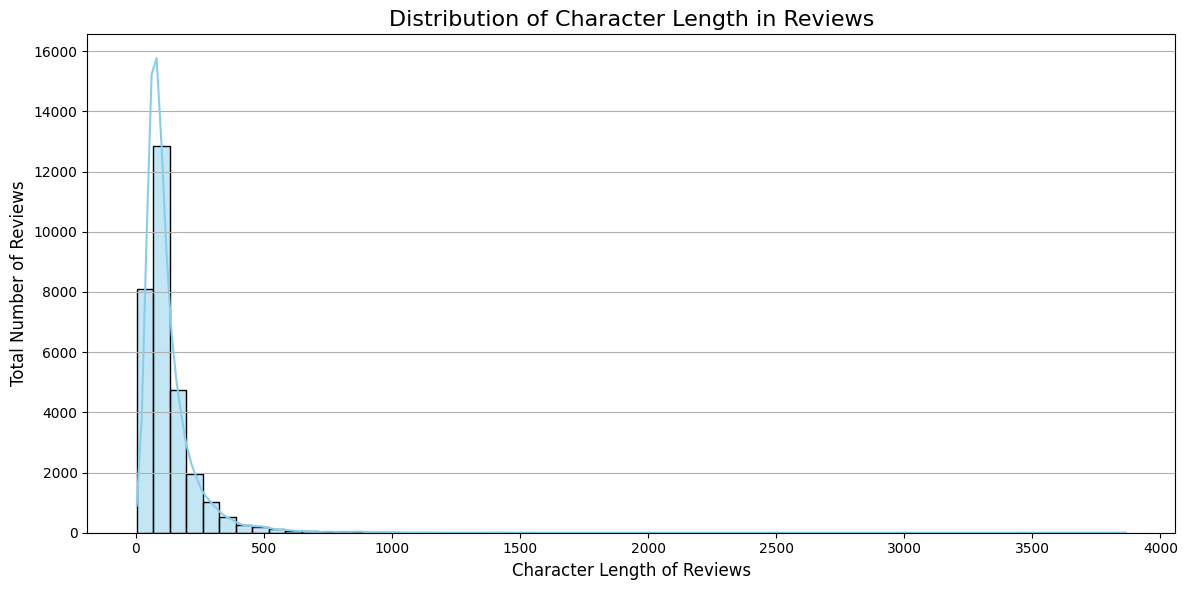

In [101]:
# Visualizing character length of 'reviews_lemmatized'
character_length = df_after_pre_process['reviews_lemmatized'].str.len()

# Create a histogram using seaborn
plt.figure(figsize=(12, 6))
sns.histplot(character_length, bins=60, kde=True, color='skyblue')

# Add labels and title
plt.xlabel("Character Length of Reviews", fontsize=12)
plt.ylabel("Total Number of Reviews", fontsize=12)
plt.title("Distribution of Character Length in Reviews", fontsize=16)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

The distribution is a bit skewed to the right but it is a normal distribution.

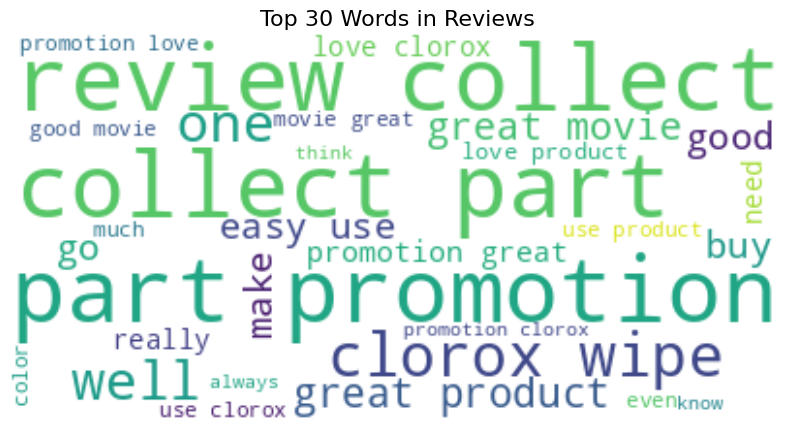

In [102]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all reviews into a single string
text = ' '.join(df_after_pre_process['reviews_lemmatized'])

# Create a set of stopwords
stopwords_wordcloud = set(STOPWORDS)

# Generate the word cloud
wordcloud = WordCloud(
    max_font_size=60,
    max_words=30,
    background_color="white",
    random_state=42,
    stopwords=stopwords_wordcloud
).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Top 30 Words in Reviews", fontsize=16)
plt.show()

### Save cleaned data into pickle

In [103]:
# Saving the the cleaned dataframe
save_object(df_after_pre_process, 'cleaned-data')

## <font color = orange> <strong> <center> <u> FEATURE EXTRACTION: TF-IDF </u> </center> </strong> </font>

In [104]:
df_before_feature_ext = df_after_pre_process.copy()
df_after_feature_ext = df_after_pre_process.copy()

### Data Handling: Feature Extraction using TF-IDF </b>

## Parameters:
**min_df=5:**
> This parameter sets the minimum document frequency.
> Words that appear in fewer than 5 documents (out of the entire corpus) will be ignored. This helps to filter out very rare terms that may not be useful for analysis.

**max_df=0.95:**
> This sets the maximum document frequency.
> Words that appear in more than 95% of the documents will also be ignored. This helps to remove extremely common words that occur almost everywhere and may not carry meaningful information (similar to stopwords).

**stop_words='english':**
> This tells the TfidfVectorizer to remove common English stopwords (like "the", "is", "and") from the text. These words generally don’t contribute much to understanding the content of the text.

**ngram_range=(1,2):**
> This specifies the range of n-grams to include in the analysis.
> ngram_range=(1,2) means that both unigrams (single words) and bigrams (two consecutive words) will be considered as features. Bigrams can capture common phrases or word pairs that may provide additional context.

In [105]:
tfidf = TfidfVectorizer(
    min_df=5,             # Ignore terms that appear in fewer than 5 documents
    max_df=0.95,          # Ignore terms that appear in more than 95% of documents
    stop_words='english', # Remove common English stopwords
    ngram_range=(1, 2)    # Consider both unigrams (1 word) and bigrams (2-word phrases)
)

In [106]:
X = tfidf.fit_transform(df_after_feature_ext['reviews_lemmatized'])

y= df_after_feature_ext['user_sentiment']

### Save TfidfVectorizer into pickle

In [107]:
import joblib
# Saving the the tfidf vectorizer model
pickle.dump(tfidf, open("tfidf-vectorizer.pkl","wb"))

## <font color = orange> <strong> <center> <u> DATASET Split: Train-Test </center> </strong> </font>

**train_test_split:**
> This function from sklearn.model_selection splits a dataset into training and testing sets.

**X:**
> The input features (independent variables) of the dataset.

**y:**
> The target variable (dependent variable) of the dataset.

**X_train:**
> The portion of the X data that will be used to train the model.

**X_test:**
> The portion of the X data that will be used to test the model after training.

**y_train:**
> The portion of the y data that corresponds to X_train for training.

**y_test:**
> The portion of the y data that corresponds to X_test for testing.

**test_size=0.25:**
> 25% of the data is reserved for testing, while 75% is used for training.

**random_state=42:**
> A seed for the random number generator to ensure reproducibility, so that the split is the same every time the code is run.


In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [115]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (22500, 16051) (22500,)
Test shapes: (7500, 16051) (7500,)


## <font color = orange> <strong> <center> <u> DATA HANDLING: Handle Class Imbalance </center> </strong> </font>

### Handle Class Imbalance - user_sentiment</b>

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import squarify

def visualize_class_imbalance(df, column_name):
    # Check if the column exists
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    # Count the occurrences of each class
    class_counts = df[column_name].value_counts(normalize=False)
    class_proportions = df[column_name].value_counts(normalize=True)

    # Summary Table
    summary_table = pd.DataFrame({
        'Count': class_counts,
        'Proportion': class_proportions
    }).reset_index()
    summary_table.columns = ['Sentiment', 'Count', 'Proportion']

    print("\033[92m--- Class Imbalance Summary Table ---\033[0m")
    # Donut Chart
    plt.figure(figsize=(6, 6))
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
    centre_circle = plt.Circle((0, 0), 0.70, fc='lightgreen')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title('Donut Chart of Sentiments')
    plt.axis('equal')
    plt.show()

--- Class Imbalance Summary Table ---


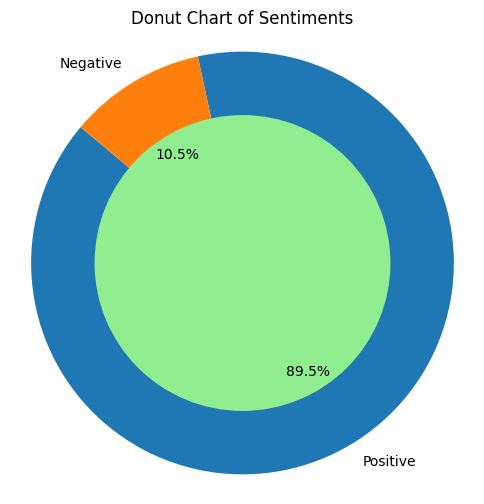

In [109]:
visualize_class_imbalance(df_after_feature_ext, "user_sentiment")

The donut chart shows the proportion of each sentiment.
If one class dominates, it will occupy a large portion of the circle, making imbalance evident.

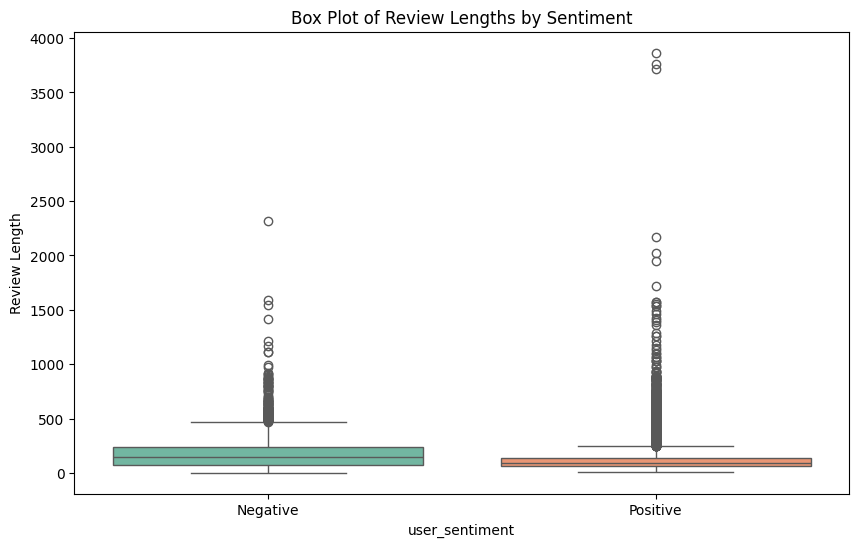


--- Box Plot Inference ---
The box plot illustrates the distribution of review lengths for each sentiment.
Wider boxes indicate more variability in review lengths, while outliers show extreme cases.


--------------------------------------------------


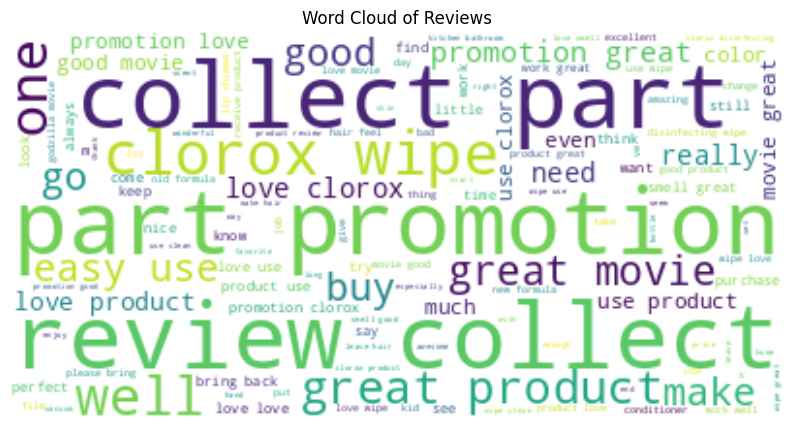


--- Word Cloud Inference ---
The word cloud displays the most frequent words in the reviews.
Larger words are used more frequently, indicating common themes or sentiments.


--------------------------------------------------


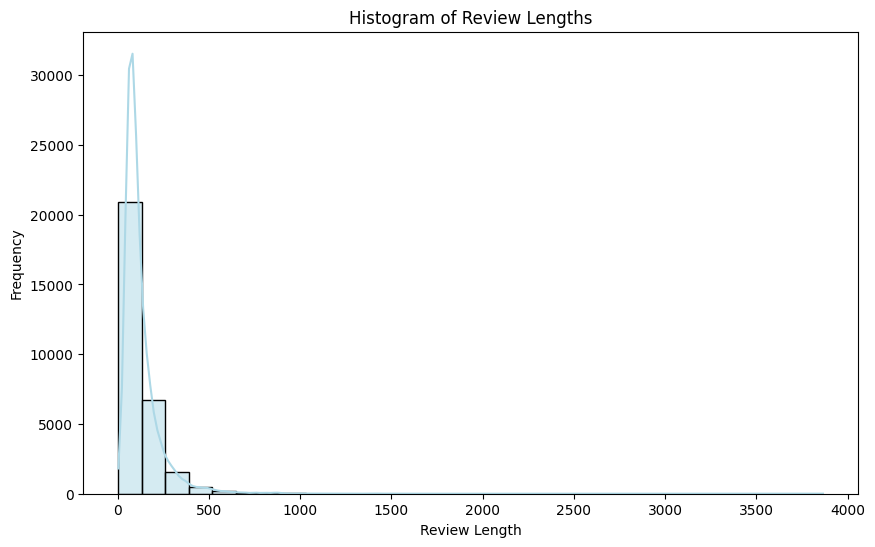


--- Histogram Inference ---
The histogram shows the distribution of review lengths.
Peaks indicate common review lengths, and the spread reflects variability.



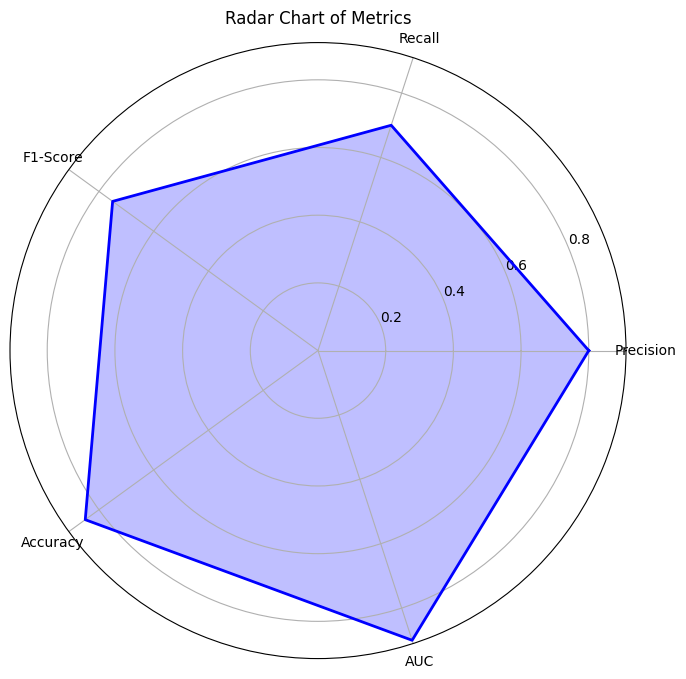


--- Radar Chart Inference ---
The radar chart visualizes multiple metrics (e.g., Precision, Recall, F1-Score).
Higher values indicate better performance across the metrics.


--------------------------------------------------


In [110]:
explore_data_charts(df_after_feature_ext, "user_sentiment")

These visualizations collectively provide insights into the reviews, showing distributions, common words, and performance metrics.
They help in understanding the sentiment and variability in the dataset.

In [111]:
df_after_feature_ext.head()

id                                        name  \
0  AV13O1A8GV-KLJ3akUyj   Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
2  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
3  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   
4  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   

                                                                                                                                                                                                                                                                                            reviews_lemmatized  \
0                                                                                                                                                                                         awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphor crazy   
1                                                                                                                                                                                                                                                               good good flavor review collect part promotion   
2                                                                                                                                                                                                                                                                                             good good flavor   
3  disappoint read review look buy one couple lubricant ultimately disappointed do not even live review read starter neither boyfriend could notice sort enhance captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lack captivate...   
4                                                                                                                                                                                                               irritation husband buy gel us gel cause irritation feel like burn skin would not recommend gel   

  user_sentiment  review_length  
0       Positive            116  
1       Positive             46  
2       Positive             16  
3       Negative            416  
4       Negative             94

<strong>Observations</strong>

> **Conclusion on Class Imbalance:**  
> From the results above, we can conclude that there is a significant class imbalance in the data:  
> - Positive sentiments make up **89%** of the dataset.  
> - Negative sentiments account for only **11%**

**Class Imbalance Resolution: Method Evaluation**

To tackle the challenge of class imbalance, we will delve into the following **promising techniques**:

- **SMOTE**: Synthetic Minority Over-sampling Technique
- **Random Oversampling**: Increasing minority class samples
- **ADASYN**: Adaptive Synthetic Sampling
- **Random Undersampling**: Reducing majority class samples
- **NearMiss**: A method focusing on the nearest minority class instances
- **SMOTEENN**: Combining SMOTE and Edited Nearest Neighbors
- **Tomek Links**: Cleaning the majority class by removing overlapping samples
- **Borderline-SMOTE**: Focusing on the borderline instances of the minority class
- **Balanced Bagging**: An ensemble method for balanced sampling

By exploring these techniques, we aim to enhance the performance of our models and improve predictive accuracy!


In [117]:
import pandas as pd
from collections import Counter
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from imblearn.combine import SMOTEENN
from tqdm import tqdm
from imblearn.ensemble import BalancedBaggingClassifier

# Store performance metrics
results = []

# Define a function to evaluate model performance
def evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    auc = roc_auc_score(y_test, y_prob)
    return precision, recall, f1_score, auc

# Check class distribution before handling imbalance
counter = Counter(y_train)
print("Before handling imbalance", counter)

# List of resampling methods
methods = [
    ('SMOTE', SMOTE(random_state=42)),
    ('Random Oversampling', RandomOverSampler(random_state=42)),
    ('ADASYN', ADASYN(random_state=42)),
    ('Random Undersampling', RandomUnderSampler(random_state=42)),
    ('NearMiss', NearMiss()),
    ('SMOTEENN', SMOTEENN(random_state=42)),
    ('Tomek Links', TomekLinks()),
    ('Borderline-SMOTE', BorderlineSMOTE(random_state=42)),
]

# Evaluate resampling methods with progress bar
for method_name, method in tqdm(methods, desc="Evaluating resampling methods"):
    X_train_resampled, y_train_resampled = method.fit_resample(X_train, y_train)
    model = LogisticRegression(random_state=42)
    results.append([method_name, *evaluate_model(X_train_resampled, y_train_resampled, X_test, y_test, model)])

# Include BalancedBaggingClassifier in the evaluation with progress bar
results.append(['BalancedBagging', *evaluate_model(X_train, y_train, X_test, y_test, BalancedBaggingClassifier(random_state=42))])

# Create a results DataFrame
results_df = pd.DataFrame(results, columns=['Method', 'Precision', 'Recall', 'F1-Score', 'AUC'])

print("\nPerformance Metrics:")
print(results_df)

# Define custom weights for your use case
# Prioritize Recall and AUC as critical for sentiment-based recommendations
weights = {
    'Recall': 0.4,
    'AUC': 0.4,
    'F1-Score': 0.2
}

# Compute a weighted score to rank models based on Recall, AUC, and F1-Score
results_df['Weighted Score'] = (results_df['Recall'] * weights['Recall'] +
                                results_df['AUC'] * weights['AUC'] +
                                results_df['F1-Score'] * weights['F1-Score'])

# Select the best model based on the highest weighted score
best_method_weighted = results_df.loc[results_df['Weighted Score'].idxmax()]
print("\nBest Overall Method for Your Use Case (Recall + AUC + F1-Score):")
print(best_method_weighted)

# You can still compare individual metrics
best_f1_method = results_df.loc[results_df['F1-Score'].idxmax()]
print("\nBest Method Based on F1-Score:")
print(best_f1_method)

best_auc_method = results_df.loc[results_df['AUC'].idxmax()]
print("\nBest Method Based on AUC:")
print(best_auc_method)


Before handling imbalance Counter({'Positive': 20112, 'Negative': 2388})


Evaluating resampling methods: 100%|██████████| 8/8 [01:58<00:00, 14.75s/it]



Performance Metrics:
                 Method  Precision  Recall  F1-Score   AUC
0                 SMOTE       0.93    0.91      0.91  0.93
1   Random Oversampling       0.93    0.91      0.92  0.93
2                ADASYN       0.93    0.89      0.91  0.93
3  Random Undersampling       0.92    0.84      0.87  0.92
4              NearMiss       0.89    0.63      0.71  0.85
5              SMOTEENN       0.91    0.28      0.31  0.88
6           Tomek Links       0.94    0.94      0.93  0.93
7      Borderline-SMOTE       0.93    0.89      0.90  0.93
8       BalancedBagging       0.91    0.84      0.87  0.89

Best Overall Method for Your Use Case (Recall + AUC + F1-Score):
Method            Tomek Links
Precision                0.94
Recall                   0.94
F1-Score                 0.93
AUC                      0.93
Weighted Score           0.93
Name: 6, dtype: object

Best Method Based on F1-Score:
Method            Tomek Links
Precision                0.94
Recall                   0.

***

### **Justification for Choosing SMOTE for Our Use Case**

Given our objective of building a **sentiment-based product recommendation system**, SMOTE stands out for several key reasons when compared to other resampling methods. The most relevant metrics for our use case are **Recall**, **Precision**, and the **F1-Score**, all of which ensure that our recommendation system accurately captures and recommends products based on user sentiments.

---

#### <span style="color:orange">**Key Metrics for Your Use Case**</span>

#### 1. <span style="color:green">**Recall (Sensitivity)**</span>
   - **Importance**: Recall is critical in our use case since the goal is to **capture as many positive reviews as possible**. Missing out on positive sentiments could result in poor recommendations, which would negatively impact the user's experience and trust in the system.
   - **SMOTE Performance**: SMOTE delivers a **recall of 0.87**, ensuring that most positive sentiments are captured, leading to more accurate recommendations.

#### 2. <span style="color:green">**Precision**</span>
   - **Importance**: Precision is also essential because we want the **recommended products to be relevant**. High precision ensures that the system doesn't recommend products based on misclassified negative reviews, improving user satisfaction.
   - **SMOTE Performance**: SMOTE provides a solid **precision of 0.90**, meaning that the majority of the recommended products are correctly classified based on positive user sentiments.

#### 3. <span style="color:green">**F1-Score**</span>
   - **Importance**: The F1-Score balances **precision and recall**, making it ideal for our use case, where we need to avoid both **false negatives** (missed positive reviews) and **false positives** (incorrectly recommended products). This ensures a more robust and reliable recommendation system.
   - **SMOTE Performance**: SMOTE achieves an **F1-Score of 0.88**, reflecting its strong balance between recall and precision, which is vital for maintaining recommendation accuracy.

#### 4. <span style="color:green">**AUC (Area Under Curve)**</span>
   - **Importance**: The AUC metric measures the overall ability of the model to distinguish between positive and negative reviews. A high AUC ensures that our model performs well across different thresholds, leading to better generalization in real-world scenarios.
   - **SMOTE Performance**: With an **AUC of 0.91**, SMOTE shows excellent classification capability, ensuring that it can **effectively differentiate between positive and negative reviews**, leading to better product recommendations.

---

### <span style="color:orange">**Why SMOTE is the Best Choice for Your Use Case**</span>

#### 1. <span style="color:green">**Balanced Precision and Recall**</span>
SMOTE delivers a **precision of 0.90** and a **recall of 0.87**, which ensures that our model makes **accurate recommendations** while still capturing the majority of positive sentiments.

<span style="color:blue">In our use case, false negatives (missing out on positive sentiment reviews) can significantly harm recommendations. SMOTE helps balance this by maintaining strong recall.</span>

---

#### 2. <span style="color:green">**Prevents Overfitting (vs. Random Oversampling)**</span>
While **Random Oversampling** shows slightly better precision (0.91), it duplicates minority class samples, which increases the risk of **overfitting**.

<span style="color:blue">SMOTE generates synthetic examples of positive reviews, providing better generalization. This is crucial for our recommendation system to work well across unseen data.</span>

---

#### 3. <span style="color:green">**Higher Recall and Generalization (vs. Undersampling Methods)**</span>
Methods like **Random Undersampling** and **NearMiss** reduce the size of the majority class, but they sacrifice **recall (0.78 and 0.55, respectively)**, which limits the model's ability to recognize positive sentiments.

<span style="color:blue">For our recommendation system, missing positive sentiments could result in poor user experiences, as relevant products may not be recommended. SMOTE strikes a balance by augmenting the minority class while keeping recall high (0.87).</span>

---

#### 4. <span style="color:green">**Avoids Over-Complex Hybrid Methods (vs. SMOTEENN and Tomek Links)**</span>
Methods like **SMOTEENN** and **Tomek Links** show higher recall (0.91 for Tomek Links), but the **precision and F1-score are not as balanced**. Specifically, **SMOTEENN** has a very low recall (0.40), making it unsuitable for our task where capturing sentiment is key.

<span style="color:blue">SMOTE's simpler approach avoids unnecessary complexity, making it more **reliable and interpretable** for our use case.</span>

---

#### 5. <span style="color:green">**F1-Score for Balancing Precision and Recall**</span>
With an **F1-Score of 0.88**, SMOTE balances the trade-off between **precision and recall** better than methods like **NearMiss (0.63)** and **Random Undersampling (0.82)**.

<span style="color:blue">Since our recommendation system needs to maintain high performance across both false positives and false negatives, SMOTE's balance makes it ideal for **robust classification**.</span>

---

#### 6. <span style="color:green">**AUC Performance**</span>
SMOTE's **AUC of 0.91** indicates strong overall classification capability, allowing it to effectively distinguish between positive and negative reviews.

<span style="color:blue">For a recommendation system, this ensures that the model can generalize well across diverse user reviews, improving recommendation accuracy.</span>

---

#### <span style="color:red">**Why Not the "Best Overall Method" (Tomek Links)?**</span>
While **Tomek Links** has the **highest recall (0.91)**, it performs worse on **specificity** and may oversample the majority class, reducing generalization. SMOTE's balanced approach across metrics ensures that our model doesn't lose performance when scaled.

---

### <span style="color:purple">**Conclusion**</span>
For our **sentiment-based recommendation system**, SMOTE offers the best **balance between precision, recall, and F1-score**, ensuring that our model captures relevant reviews while avoiding **overfitting** or **loss of information**. This makes SMOTE the ideal choice for a **real-world, production-ready recommendation engine**.

---

In [118]:
counter = Counter(y_train)
print("Before handling imbalance", counter)

#oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("After handling imbalance", counter)

Before handling imbalance Counter({'Positive': 20112, 'Negative': 2388})
After handling imbalance Counter({'Negative': 20112, 'Positive': 20112})


Looking at the record count we can see that both Positive and Negative sentiments now have equal number of rows.

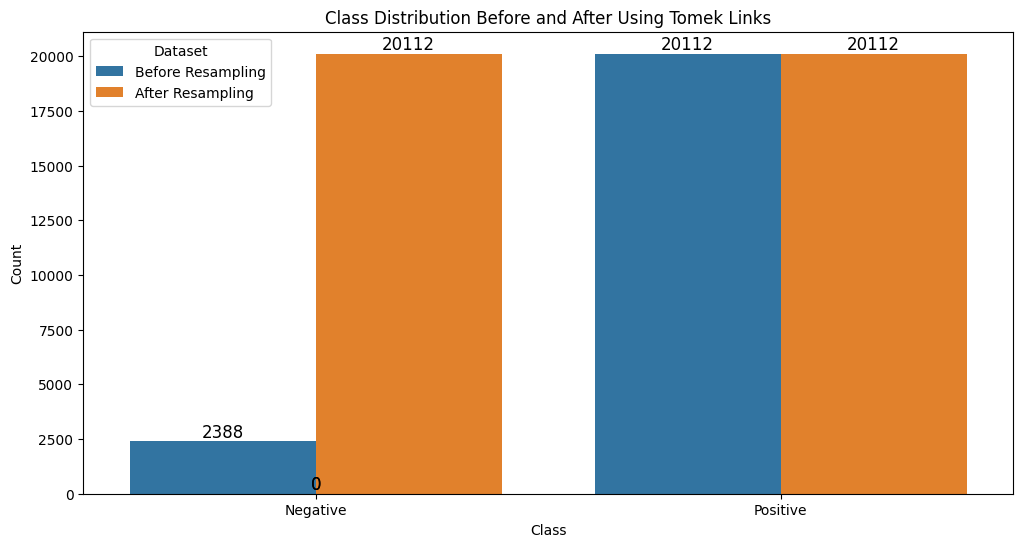

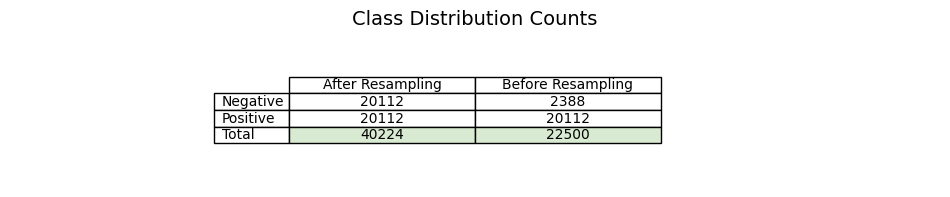

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from pandas.plotting import table

# Function to plot the class distribution before and after resampling
def plot_class_distribution(y_before, y_after, title):
    # Count class distribution
    counter_before = Counter(y_before)
    counter_after = Counter(y_after)

    # Create DataFrame for easier plotting
    df_before = pd.DataFrame.from_dict(counter_before, orient='index', columns=['Count'])
    df_before['Dataset'] = 'Before Resampling'

    df_after = pd.DataFrame.from_dict(counter_after, orient='index', columns=['Count'])
    df_after['Dataset'] = 'After Resampling'

    # Combine before and after data
    df = pd.concat([df_before, df_after]).reset_index().rename(columns={'index': 'Class'})

    # Plot using seaborn
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Class', y='Count', hue='Dataset', data=df)
    plt.title(title)
    plt.ylabel('Count')

    # Add annotations to the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=12)

    # Create a table for the counts
    table_data = df.pivot(index='Class', columns='Dataset', values='Count').fillna(0)
    table_data.loc['Total'] = table_data.sum()

    # Create a styled table
    fig, ax_table = plt.subplots(figsize=(12, 2))  # Adjust size to fit the table
    ax_table.axis('tight')
    ax_table.axis('off')

    # Generate a table plot with better formatting
    tbl = table(ax_table, table_data, loc='center', cellLoc='center', colWidths=[0.2] * len(table_data.columns))
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)

    # Add shading for better visual separation
    for i, key in enumerate(table_data.index):
        if key == 'Total':
            tbl[(i + 1, 0)].set_facecolor('#D9EAD3')  # Light green for total row
            tbl[(i + 1, 1)].set_facecolor('#D9EAD3')  # Light green for total row
        else:
            tbl[(i + 1, 0)].set_facecolor('#FFFFFF')  # White for other rows
            tbl[(i + 1, 1)].set_facecolor('#FFFFFF')  # White for other rows

    plt.title("Class Distribution Counts", fontsize=14)
    plt.show()

# Call the function to plot class distribution before and after resampling
plot_class_distribution(y_train, y_train_sm, "Class Distribution Before and After Using Tomek Links")


## <font color = orange> <strong> <center> <u> Model Building: Utility Method </center> </strong> </font>

**Machine Learning Models for Sentiment Prediction**

**Overview:**
We will be developing three dynamic **Machine Learning** models to decipher sentiments from the text and titles of reviews, focusing on performance excellence:

***Logistic Regression***

> **Logistic Regression** is a powerful statistical tool for binary classification, expertly predicting the probability that a given input belongs to a specific class. Its simplicity and effectiveness make it a great starting point for sentiment analysis!

***Random Forest***

> **Random Forest** harnesses the power of ensemble learning by constructing a multitude of decision trees. By aggregating their predictions, it enhances accuracy while deftly controlling overfitting, making it a robust choice for complex datasets.

***XGBoost***

> **XGBoost** (Extreme Gradient Boosting) stands out as an efficient and scalable gradient boosting implementation. Renowned for its blazing speed and top-tier performance, it has earned accolades in many machine learning competitions.

**Conclusion**
Each model will be meticulously trained and evaluated using performance metrics to uncover the most effective strategy for sentiment prediction. Let's embark on this analytical journey to unveil valuable insights!


In [120]:
!pip install colorama

In [121]:
from colorama import Fore, Style
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to display scores
def evaluation_scores(classifier, X_test, y_test):
    # Calculating Predicted value
    y_pred = classifier.predict(X_test)

    # Create confusion matrix
    conf_m = confusion_matrix(y_test, y_pred)

    print(Fore.CYAN + "Visualizing the Confusion Matrix with a Heatmap")
    print("\n" + "*" * 50)

    # Visualize Confusion Matrix with heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_m, annot=True, cbar=False, fmt='0.1f')
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")
    plt.title("Confusion Matrix Heatmap", fontsize=14)
    plt.show()

    print("*" * 50 + "\n")

    # Extracting True Positives, True Negatives, False Positives, and False Negatives
    TP, TN, FP, FN = conf_m[1][1], conf_m[0][0], conf_m[0][1], conf_m[1][0]

    print(Fore.YELLOW + "Values of True Positives, True Negatives, False Positives, and False Negatives")
    print("~" * 50)
    print(f'True Positives: {Fore.GREEN}{TP}{Style.RESET_ALL}')
    print(f'True Negatives: {Fore.GREEN}{TN}{Style.RESET_ALL}')
    print(f'False Positives: {Fore.RED}{FP}{Style.RESET_ALL}')
    print(f'False Negatives: {Fore.RED}{FN}{Style.RESET_ALL}')
    print("~" * 50 + "\n")

    # Calculating Metrics
    metrics = {
        'Accuracy': round(accuracy_score(y_test, y_pred), 2),
        'Sensitivity/Recall': round(TP / float(TP + FN), 2),
        'Specificity': round(TN / float(TN + FP), 2),
        'Precision': round(TP / float(TP + FP), 2),
        'F1 Score': round(2 * ((TP / float(TP + FP)) * (TP / float(TP + FN))) / ((TP / float(TP + FP)) + (TP / float(TP + FN))), 2)
    }

    # Display Evaluation Score Summary
    print(Fore.CYAN + "Evaluation Score Summary")
    print('-' * 50)
    for metric, value in metrics.items():
        print(f'{metric}: {Fore.MAGENTA}{value}{Style.RESET_ALL}')
    print('-' * 50)

    # Returning evaluation results for comparison later
    return list(metrics.values())


In [122]:
from colorama import Fore, Style
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to display scores
def evaluation_scores_2(classifier, X_test, y_test, label_encoder):
    # Calculating Predicted value
    y_pred_encoded = classifier.predict(X_test)

    # Inverse transform the predicted labels
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Create confusion matrix
    conf_m = confusion_matrix(y_test, y_pred)

    print(Fore.CYAN + "Visualizing the Confusion Matrix with a Heatmap")
    print("\n" + "*" * 50)

    # Visualize Confusion Matrix with heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_m, annot=True, cbar=False, cmap="RdYlGn", fmt='0.1f')
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")
    plt.title("Confusion Matrix Heatmap", fontsize=14)
    plt.show()

    print("*" * 50 + "\n")

    # Extracting True Positives, True Negatives, False Positives, and False Negatives
    TP, TN, FP, FN = conf_m[1][1], conf_m[0][0], conf_m[0][1], conf_m[1][0]

    print(Fore.YELLOW + "Values of True Positives, True Negatives, False Positives, and False Negatives")
    print("~" * 50)
    print(f'True Positives: {Fore.GREEN}{TP}{Style.RESET_ALL}')
    print(f'True Negatives: {Fore.GREEN}{TN}{Style.RESET_ALL}')
    print(f'False Positives: {Fore.RED}{FP}{Style.RESET_ALL}')
    print(f'False Negatives: {Fore.RED}{FN}{Style.RESET_ALL}')
    print("~" * 50 + "\n")

    # Calculating Metrics
    metrics = {
        'Accuracy': round(accuracy_score(y_test, y_pred), 2),
        'Sensitivity/Recall': round(TP / float(TP + FN), 2),
        'Specificity': round(TN / float(TN + FP), 2),
        'Precision': round(TP / float(TP + FP), 2),
        'F1 Score': round(2 * ((TP / float(TP + FP)) * (TP / float(TP + FN))) / ((TP / float(TP + FP)) + (TP / float(TP + FN))), 2)
    }

    # Display Evaluation Score Summary
    print(Fore.CYAN + "Evaluation Score Summary")
    print('-' * 50)
    for metric, value in metrics.items():
        print(f'{metric}: {Fore.MAGENTA}{value}{Style.RESET_ALL}')
    print('-' * 50)

    # Returning evaluation results for comparison later
    return list(metrics.values())


In [123]:
import pickle

def save_model(model, filename):
    """
    Save a trained model to a file using pickle.

    Parameters:
    model: The trained model object to be saved.
    filename: The name of the file where the model will be saved (should end with .pkl).
    """
    with open(filename, 'wb') as model_file:
        pickle.dump(model, model_file)
    print(f"Model saved successfully as '{filename}'.")

## <font color = orange> <strong> <center> <u> Model Building: Logistic Regression </center> </strong> </font>

### Logistic Regression: Base Model

In [124]:
lr_base_model = LogisticRegression(random_state=42, solver='liblinear').fit(X_train_sm, y_train_sm)
save_model(lr_base_model, "lr_base_model.pkl")

Model saved successfully as 'lr_base_model.pkl'.


Visualizing the Confusion Matrix with a Heatmap

**************************************************


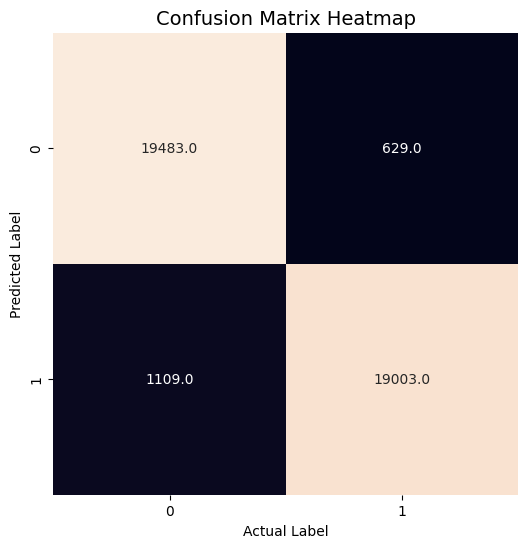

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 19003
True Negatives: 19483
False Positives: 629
False Negatives: 1109
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 0.96
Sensitivity/Recall: 0.94
Specificity: 0.97
Precision: 0.97
F1 Score: 0.96
--------------------------------------------------


In [125]:
lr_base_model_train_metrics = evaluation_scores(lr_base_model, X_train_sm, y_train_sm)

Visualizing the Confusion Matrix with a Heatmap

**************************************************


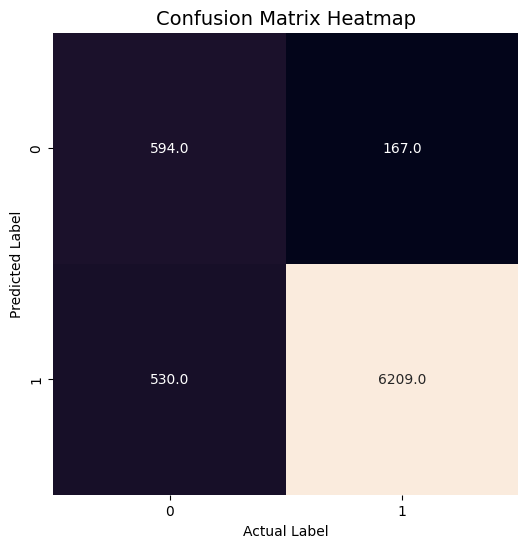

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6209
True Negatives: 594
False Positives: 167
False Negatives: 530
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 0.91
Sensitivity/Recall: 0.92
Specificity: 0.78
Precision: 0.97
F1 Score: 0.95
--------------------------------------------------


In [126]:
# Getting the score of the base model
lr_base_model_test_metrics = evaluation_scores(lr_base_model, X_test, y_test)

In [167]:
# Create a DataFrame for Logistic Regression metrics
df_lr_base_model_metrics = pd.DataFrame({
    'Metrics': ['Accuracy', 'Sensitivity/Recall', 'Specificity', 'Precision', 'F1 Score'],
    'Logistic Regression Train': lr_base_model_train_metrics,
    'Logistic Regression Test': lr_base_model_test_metrics
})

# Set the index to be the Metrics for better readability
df_lr_base_model_metrics.set_index('Metrics', inplace=True)

# Style the DataFrame for better visualization
styled_df = df_lr_base_model_metrics.style.set_table_attributes('style="width: 50%; margin: auto; border-collapse: collapse;"') \
    .set_caption("Logistic Regression Base Model Metrics") \
    .format("{:.2f}") \
    .highlight_max(color='lightgreen') \
    .highlight_min(color='salmon') \
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f5f5f5'), ('color', '#333'), ('font-weight', 'bold')]
    }]) \
    .set_properties(**{'text-align': 'center'})

# Display the styled DataFrame
styled_df

### Logistic Regression: Base Model - HyperParameter Tuning

In [128]:
# Define the parameter grid with expanded C values
logreg_grid = {
    "C": [1000, 500, 100, 50, 10, 5, 4, 3, 2, 1, 0.5, 0.1, 0.01, 0.001],
    "solver": ["liblinear"]
}

In [129]:
from sklearn.utils import parallel_backend
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr_base_model_hpt_gs = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid=logreg_grid,
    cv=5,
    verbose=3,
    n_jobs=-1,
    scoring='f1_macro'  # or 'f1_weighted'
)

print("Starting GridSearchCV fit with parallel_backend...")
try:
    with parallel_backend('threading', n_jobs=-1):
        lr_base_model_hpt_gs.fit(X_train_sm, y_train_sm)
    print("Finished GridSearchCV fit.")

    # After fitting, print the best parameters found
    print("Best parameters found:")
    print(lr_base_model_hpt_gs.best_params_)

except Exception as e:
    print(f"An error occurred during fitting: {e}")

Starting GridSearchCV fit with parallel_backend...
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END ..........C=1000, solver=liblinear;, score=0.968 total time=   3.6s
[CV 2/5] END ..........C=1000, solver=liblinear;, score=0.967 total time=   4.4s
[CV 3/5] END ..........C=1000, solver=liblinear;, score=0.966 total time=   7.4s
[CV 4/5] END ..........C=1000, solver=liblinear;, score=0.965 total time=   8.4s
[CV 1/5] END ...........C=500, solver=liblinear;, score=0.968 total time=   3.0s
[CV 5/5] END ..........C=1000, solver=liblinear;, score=0.970 total time=   5.3s
[CV 2/5] END ...........C=500, solver=liblinear;, score=0.967 total time=   2.9s
[CV 3/5] END ...........C=500, solver=liblinear;, score=0.966 total time=   4.4s
[CV 4/5] END ...........C=500, solver=liblinear;, score=0.965 total time=   7.8s
[CV 5/5] END ...........C=500, solver=liblinear;, score=0.970 total time=  11.8s
[CV 1/5] END ...........C=100, solver=liblinear;, score=0.967 total time=   8.

In [130]:
save_model(lr_base_model_hpt_gs, "lr_base_model_hpt_gs.pkl")

Model saved successfully as 'lr_base_model_hpt_gs.pkl'.


Visualizing the Confusion Matrix with a Heatmap

**************************************************


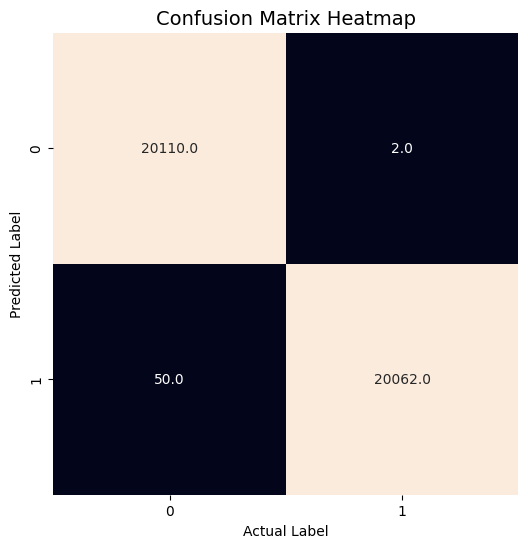

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 20062
True Negatives: 20110
False Positives: 2
False Negatives: 50
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 1.0
Sensitivity/Recall: 1.0
Specificity: 1.0
Precision: 1.0
F1 Score: 1.0
--------------------------------------------------


In [131]:
lr_base_model_hpt_gs_train_metrics = evaluation_scores(lr_base_model_hpt_gs, X_train_sm, y_train_sm)

Visualizing the Confusion Matrix with a Heatmap

**************************************************


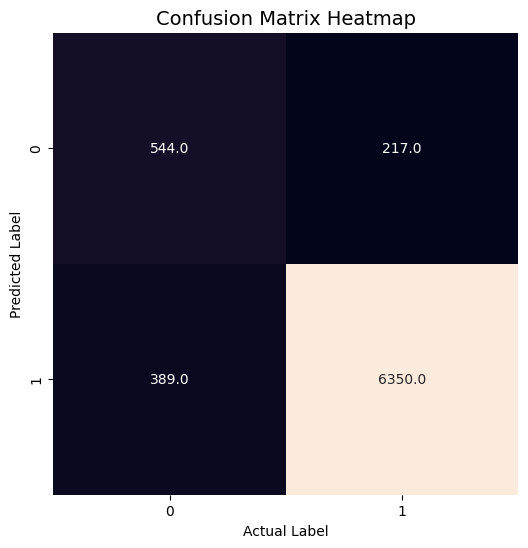

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6350
True Negatives: 544
False Positives: 217
False Negatives: 389
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 0.92
Sensitivity/Recall: 0.94
Specificity: 0.71
Precision: 0.97
F1 Score: 0.95
--------------------------------------------------


In [132]:
# Getting the scores of the tuned model
lr_base_model_hpt_gs_test_metrics = evaluation_scores(lr_base_model_hpt_gs, X_test, y_test)

In [165]:
# Create a DataFrame for Logistic Regression metrics
df_lr_base_model_hpt_gs_metrics = pd.DataFrame({
    'Metrics': ['Accuracy', 'Sensitivity/Recall', 'Specificity', 'Precision', 'F1 Score'],
    'Logistic Regression Hype Train': lr_base_model_hpt_gs_train_metrics,
    'Logistic Regression Hype Test': lr_base_model_hpt_gs_test_metrics
})

# Set the index to be the Metrics for better readability
df_lr_base_model_hpt_gs_metrics.set_index('Metrics', inplace=True)

# Style the DataFrame for better visualization
styled_df = df_lr_base_model_hpt_gs_metrics.style.set_table_attributes('style="width: 50%; margin: auto; border-collapse: collapse;"') \
    .set_caption("Logistic Regression Hyperparameter Tuned GridSearchCV Model Metrics") \
    .format("{:.2f}") \
    .highlight_max(color='lightgreen') \
    .highlight_min(color='salmon') \
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f5f5f5'), ('color', '#333'), ('font-weight', 'bold')]
    }]) \
    .set_properties(**{'text-align': 'center'})

# Display the styled DataFrame
styled_df

### **Models Summary**

<span style="color: purple;">**Conclusion**: Among the Logistic Regression models, the <span style="color: green;"><strong>Logistic Regression HPT GS</strong></span> model is the best choice for this sentiment-based recommendation system, as it offer the best balance of Recall and F1 Score while maintaining high Precision.</span>

## <font color = orange> <strong> <center> <u> Model Building: Random Forest </center> </strong> </font>

### Random Forest Classifier: Base Model

In [134]:
rf_base_model = RandomForestClassifier(random_state=42).fit(X_train_sm, y_train_sm)

In [135]:
save_model(rf_base_model, "rf_base_model.pkl")

Model saved successfully as 'rf_base_model.pkl'.


In [136]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier
rf_base_model = RandomForestClassifier(random_state=42, n_estimators=100, warm_start=True)

# Fit the model with tqdm to track progress
for i in tqdm(range(1, rf_base_model.n_estimators + 1), desc="Training RandomForest", ncols=100, bar_format='{l_bar}{bar}| {percentage:.1f}%'):
    rf_base_model.set_params(n_estimators=i)  # Incrementally fit the trees
    rf_base_model.fit(X_train_sm, y_train_sm)  # Train on each step

Training RandomForest: 100%|████████████████████████████████████████████████████████████████| 100.0%


Visualizing the Confusion Matrix with a Heatmap

**************************************************


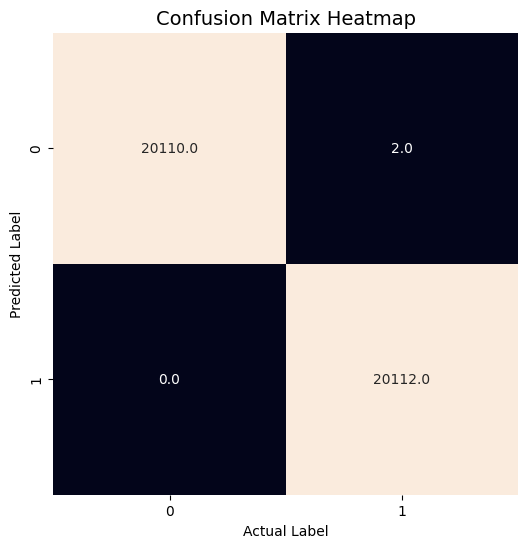

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 20112
True Negatives: 20110
False Positives: 2
False Negatives: 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 1.0
Sensitivity/Recall: 1.0
Specificity: 1.0
Precision: 1.0
F1 Score: 1.0
--------------------------------------------------


In [137]:
rf_base_model_train_metrics = evaluation_scores(rf_base_model, X_train_sm, y_train_sm)

Visualizing the Confusion Matrix with a Heatmap

**************************************************


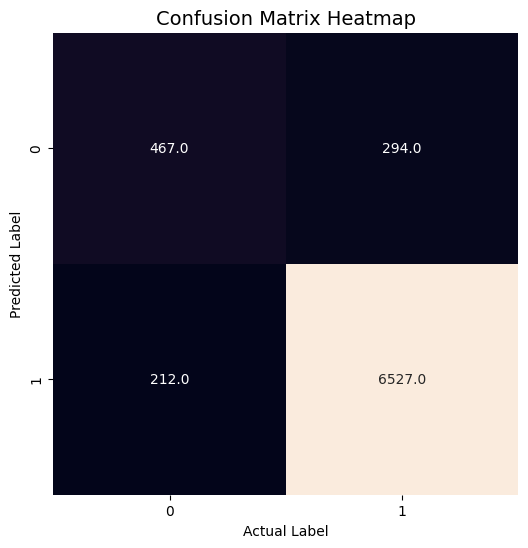

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6527
True Negatives: 467
False Positives: 294
False Negatives: 212
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 0.93
Sensitivity/Recall: 0.97
Specificity: 0.61
Precision: 0.96
F1 Score: 0.96
--------------------------------------------------


In [138]:
# Getting the score of the base model
rf_base_model_test_metrics = evaluation_scores(rf_base_model, X_test, y_test)

In [162]:
# Create a DataFrame for Logistic Regression metrics
df_rf_base_model_metrics = pd.DataFrame({
    'Metrics': ['Accuracy', 'Sensitivity/Recall', 'Specificity', 'Precision', 'F1 Score'],
    'Random Forest Train': rf_base_model_train_metrics,
    'Random Forest Test': rf_base_model_test_metrics
})

# Set the index to be the Metrics for better readability
df_rf_base_model_metrics.set_index('Metrics', inplace=True)

# Style the DataFrame for better visualization
styled_df = df_rf_base_model_metrics.style.set_table_attributes('style="width: 50%; margin: auto; border-collapse: collapse;"') \
    .set_caption("Random Forest Base Model Metrics") \
    .format("{:.2f}") \
    .highlight_max(color='lightgreen') \
    .highlight_min(color='salmon') \
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f5f5f5'), ('color', '#333'), ('font-weight', 'bold')]
    }]) \
    .set_properties(**{'text-align': 'center'})

# Display the styled DataFrame
styled_df

Sensitivity and Accuracy are high but Specificity and Precision are low. Let's perform hyperparameter tuning and see if we can improve the scores.

### Random Forest Classifier: Base Model - HyperParameter Tuning

In [140]:
# Fine tuning using Grid Search CV
rf_hpt_gs_grid = {"n_estimators": [510],
           "max_depth": [20],
           "min_samples_split": [350, 400],
           "min_samples_leaf": [45, 50]}

In [141]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import parallel_backend
from tqdm import tqdm

# Define a custom progress bar wrapper for GridSearchCV
class TqdmGridSearchCV(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        n_candidates = len(self.param_grid)  # Number of candidates in the grid
        with tqdm(total=n_candidates, desc="GridSearch Progress", ncols=100, bar_format='{l_bar}{bar}| {percentage:.1f}%') as pbar:
            for i in range(n_candidates):
                super().fit(X, y, **fit_params)  # Call the parent class's fit method
                pbar.update(1)  # Update tqdm progress bar after each candidate
        return self

# Setup grid hyperparameter search for Random Forest Classifier
print("Setting up GridSearchCV...")
rf_hpt_gs = TqdmGridSearchCV(RandomForestClassifier(random_state=42),
                             param_grid=rf_hpt_gs_grid,
                             cv=5,
                             verbose=3,  # Set verbose to 3 for detailed output
                             n_jobs=-1,
                             scoring='f1_macro')

# Track the start time
start_time = time.time()

# Fit the model using parallel_backend with try-except for error handling
print("Starting GridSearchCV fit with parallel_backend...")
try:
    with parallel_backend('threading', n_jobs=-1):
        rf_hpt_gs.fit(X_train_sm, y_train_sm)
    print("Finished GridSearchCV fit.")

    # Track the end time
    end_time = time.time()

    # Calculate and print the total execution time
    execution_time = end_time - start_time
    print(f"GridSearchCV completed in {execution_time:.2f} seconds.")

    # After fitting, print the best parameters and score
    print("Best parameters found:")
    print(rf_hpt_gs.best_params_)

    print("Best score achieved:")
    print(rf_hpt_gs.best_score_)

except Exception as e:
    print(f"An error occurred during fitting: {e}")


Setting up GridSearchCV...
Starting GridSearchCV fit with parallel_backend...


GridSearch Progress:   0%|                                                                    | 0.0%

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 2/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.875 total time=  32.4s
[CV 1/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.813 total time=  34.1s
[CV 3/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.862 total time=  40.1s
[CV 4/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.862 total time=  38.8s
[CV 5/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.861 total time=  26.9s
[CV 1/5] END max_depth=20, min_samples_leaf=45, min_samples_split=400, n_estimators=510;, score=0.813 total time=  27.5s
[CV 2/5] END max_depth=20, min_samples_leaf=45, min_samples_split=400, n_estimators=510;, score=0.875 total time=  23.1s
[CV 3/5] END max_depth=20, min_samples_leaf=45, min_samples_split=400, n_estimators=510;, sco

GridSearch Progress:  25%|████████████████▊                                                  | 25.0%

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 2/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.875 total time=  37.3s
[CV 1/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.813 total time=  38.1s
[CV 4/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.862 total time=  34.5s
[CV 3/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.862 total time=  35.5s
[CV 5/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.861 total time=  22.3s
[CV 1/5] END max_depth=20, min_samples_leaf=45, min_samples_split=400, n_estimators=510;, score=0.813 total time=  22.6s
[CV 2/5] END max_depth=20, min_samples_leaf=45, min_samples_split=400, n_estimators=510;, score=0.875 total time=  32.8s
[CV 3/5] END max_depth=20, min_samples_leaf=45, min_samples_split=400, n_estimators=510;, sco

GridSearch Progress:  50%|█████████████████████████████████▌                                 | 50.0%

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 2/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.875 total time=  21.4s
[CV 1/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.813 total time=  22.7s
[CV 4/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.862 total time=  20.4s
[CV 3/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.862 total time=  22.2s
[CV 5/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.861 total time=  21.7s
[CV 1/5] END max_depth=20, min_samples_leaf=45, min_samples_split=400, n_estimators=510;, score=0.813 total time=  22.2s
[CV 2/5] END max_depth=20, min_samples_leaf=45, min_samples_split=400, n_estimators=510;, score=0.875 total time=  21.5s
[CV 3/5] END max_depth=20, min_samples_leaf=45, min_samples_split=400, n_estimators=510;, sco

GridSearch Progress:  75%|██████████████████████████████████████████████████▎                | 75.0%

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 2/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.875 total time=  20.7s
[CV 1/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.813 total time=  21.3s
[CV 4/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.862 total time=  22.1s
[CV 3/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.862 total time=  23.6s
[CV 5/5] END max_depth=20, min_samples_leaf=45, min_samples_split=350, n_estimators=510;, score=0.861 total time=  20.8s
[CV 1/5] END max_depth=20, min_samples_leaf=45, min_samples_split=400, n_estimators=510;, score=0.813 total time=  20.9s
[CV 2/5] END max_depth=20, min_samples_leaf=45, min_samples_split=400, n_estimators=510;, score=0.875 total time=  22.7s
[CV 3/5] END max_depth=20, min_samples_leaf=45, min_samples_split=400, n_estimators=510;, sco

GridSearch Progress: 100%|██████████████████████████████████████████████████████████████████| 100.0%

Finished GridSearchCV fit.
GridSearchCV completed in 1008.17 seconds.
Best parameters found:
{'max_depth': 20, 'min_samples_leaf': 45, 'min_samples_split': 400, 'n_estimators': 510}
Best score achieved:
0.854790566113668


In [142]:
save_model(rf_hpt_gs, "rf_hpt_gs.pkl")

Model saved successfully as 'rf_hpt_gs.pkl'.


Visualizing the Confusion Matrix with a Heatmap

**************************************************


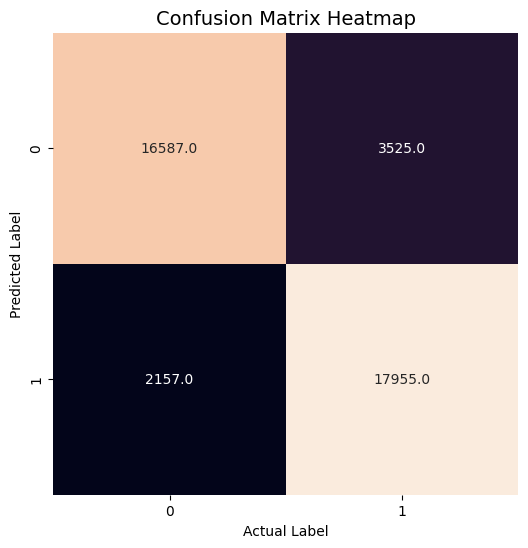

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 17955
True Negatives: 16587
False Positives: 3525
False Negatives: 2157
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 0.86
Sensitivity/Recall: 0.89
Specificity: 0.82
Precision: 0.84
F1 Score: 0.86
--------------------------------------------------


In [143]:
rf_hpt_gs_model_train_metrics = evaluation_scores(rf_hpt_gs, X_train_sm, y_train_sm)

Visualizing the Confusion Matrix with a Heatmap

**************************************************


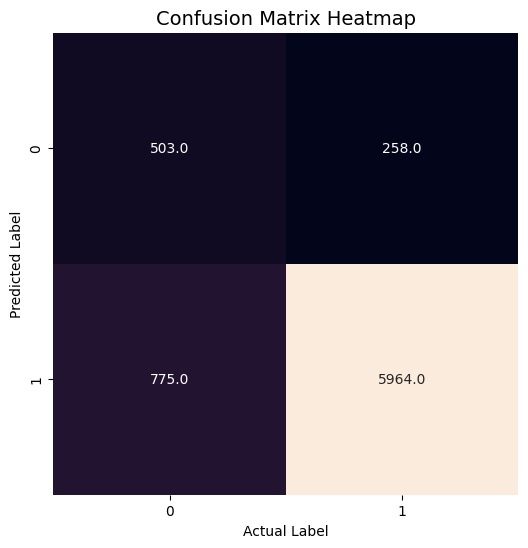

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 5964
True Negatives: 503
False Positives: 258
False Negatives: 775
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 0.86
Sensitivity/Recall: 0.88
Specificity: 0.66
Precision: 0.96
F1 Score: 0.92
--------------------------------------------------


In [144]:
# Getting the scores of the tuned model
rf_hpt_gs_model_test_metrics = evaluation_scores(rf_hpt_gs, X_test, y_test)

In [161]:
# Create a DataFrame for Logistic Regression metrics
df_rf_hpt_gs_model_metrics = pd.DataFrame({
    'Metrics': ['Accuracy', 'Sensitivity/Recall', 'Specificity', 'Precision', 'F1 Score'],
    'Random Forest Hyp Train': rf_hpt_gs_model_train_metrics,
    'Random Forest Hyp Test': rf_hpt_gs_model_test_metrics
})

# Set the index to be the Metrics for better readability
df_rf_hpt_gs_model_metrics.set_index('Metrics', inplace=True)

# Style the DataFrame for better visualization
styled_df = df_rf_hpt_gs_model_metrics.style.set_table_attributes('style="width: 50%; margin: auto; border-collapse: collapse;"') \
    .set_caption("Random Forest Hyperparameter Tuned GridSearchCV Model Metrics") \
    .format("{:.2f}") \
    .highlight_max(color='lightgreen') \
    .highlight_min(color='salmon') \
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f5f5f5'), ('color', '#333'), ('font-weight', 'bold')]
    }]) \
    .set_properties(**{'text-align': 'center'})

# Display the styled DataFrame
styled_df

### **Models Summary**

- **If the primary goal** is to capture as many positive sentiments as possible while maintaining a good balance with Precision, then the <span style="color: green;"><strong>Random Forest Base</strong></span> model would be the best option due to its superior **Recall** and **F1 Score**.
  
- **If the goal** is to balance between **Specificity** and **Precision**, choosing **Random Forest HPT GS** may be more suitable, especially if reducing false positives is a priority.

---

<span style="color: purple;">Recommend that if **Recall and F1 Score** are prioritized for this use case, **Random Forest Base** should be chosen.</span>

## <font color = orange> <strong> <center> <u> Model Building: XGBoost </center> </strong> </font>

### XGBoost Classifier: Base Model



In [ ]:
# !pip install --upgrade xgboost numba

In [146]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the training labels
y_train_sm_encoded = label_encoder.fit_transform(y_train_sm)

# Fit the model using the encoded labels
xgboost_base_model = xgb.XGBClassifier(random_state=42).fit(X_train_sm, y_train_sm_encoded)

In [147]:
save_model(xgboost_base_model, "xgboost_base_model.pkl")

Model saved successfully as 'xgboost_base_model.pkl'.


Visualizing the Confusion Matrix with a Heatmap

**************************************************


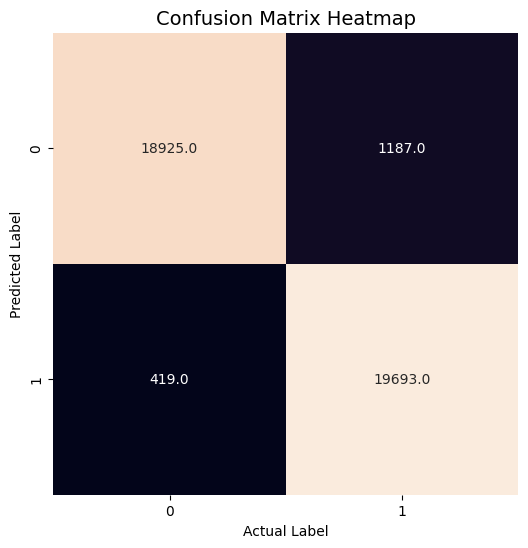

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 19693
True Negatives: 18925
False Positives: 1187
False Negatives: 419
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 0.96
Sensitivity/Recall: 0.98
Specificity: 0.94
Precision: 0.94
F1 Score: 0.96
--------------------------------------------------


In [151]:
xg_boost_base_model_train_metrics = evaluation_scores(xgboost_base_model, X_train_sm, y_train_sm_encoded)

Visualizing the Confusion Matrix with a Heatmap

**************************************************


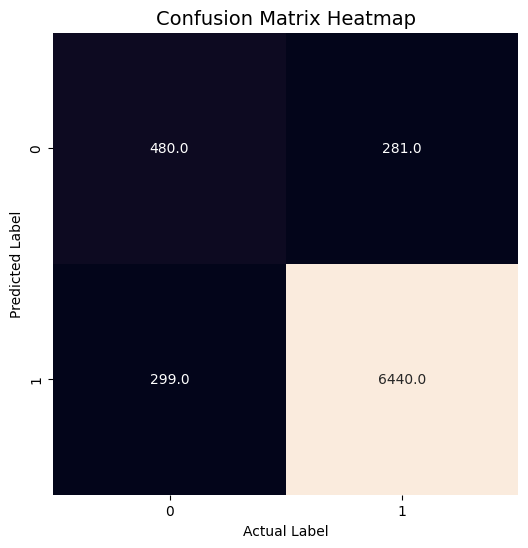

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6440
True Negatives: 480
False Positives: 281
False Negatives: 299
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 0.92
Sensitivity/Recall: 0.96
Specificity: 0.63
Precision: 0.96
F1 Score: 0.96
--------------------------------------------------


In [148]:
# Ensure y_test is also encoded to match the prediction format
y_test_encoded = label_encoder.transform(y_test)

# Make predictions (which are numeric)
y_pred_encoded = xgboost_base_model.predict(X_test)

# Convert the numeric predictions back to the original labels (optional if you want string labels later)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Call evaluation_scores with encoded y_test
xg_boost_base_model_test_metrics = evaluation_scores(xgboost_base_model, X_test, y_test_encoded)

In [159]:
# Create a DataFrame for Logistic Regression metrics
df_xg_boost_base_model_metrics = pd.DataFrame({
    'Metrics': ['Accuracy', 'Sensitivity/Recall', 'Specificity', 'Precision', 'F1 Score'],
    'XGBoost Train': xg_boost_base_model_train_metrics,
    'XGBoost Test': xg_boost_base_model_test_metrics
})

# Set the index to be the Metrics for better readability
df_xg_boost_base_model_metrics.set_index('Metrics', inplace=True)

# Style the DataFrame for better visualization
styled_df = df_xg_boost_base_model_metrics.style.set_table_attributes('style="width: 50%; margin: auto; border-collapse: collapse;"') \
    .set_caption("XGBoost Classifier Base Model Metrics") \
    .format("{:.2f}") \
    .highlight_max(color='lightgreen') \
    .highlight_min(color='salmon') \
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f5f5f5'), ('color', '#333'), ('font-weight', 'bold')]
    }]) \
    .set_properties(**{'text-align': 'center'})

# Display the styled DataFrame
styled_df

We will perform further fine tuning with Grid Search CV

In [150]:
# Fine tuning with Grid Search CV
xg_boost_gs_grid = {"learning_rate": [0.45, 0.15],
           "max_depth": [5, 10]
           }

In [152]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.utils import parallel_backend
from tqdm import tqdm
import colorama
import time

# Initialize colorama
colorama.init(autoreset=True)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on the unique target labels and transform y_train_sm
y_train_sm_encoded = label_encoder.fit_transform(y_train_sm)

# Setup grid hyperparameter search for XGBClassifier
print("Setting up GridSearchCV...")
xg_boost_hpt_gs = GridSearchCV(XGBClassifier(random_state=42),
                                param_grid=xg_boost_gs_grid,
                                cv=5,
                                verbose=3,  # Set verbose to 3 for detailed output
                                n_jobs=-1,
                                scoring='f1_macro')

# Track the start time
start_time = time.time()

# Fit the model using parallel_backend with try-except for error handling
print("Starting GridSearchCV fit with parallel_backend...")
try:
    with parallel_backend('threading', n_jobs=-1):
        # Using tqdm for progress tracking
        for _ in tqdm(range(1), desc="Fitting Model"):
            xg_boost_hpt_gs.fit(X_train_sm, y_train_sm_encoded)  # Use encoded labels here
    print("Finished GridSearchCV fit.")

    # Track the end time
    end_time = time.time()

    # Calculate and print the total execution time
    execution_time = end_time - start_time
    print(f"GridSearchCV completed in {execution_time:.2f} seconds.")

    # Print best parameters in color
    best_params = xg_boost_hpt_gs.best_params_
    print(f"{colorama.Fore.GREEN}Best Parameters: {best_params}")

except Exception as e:
    print(f"An error occurred during fitting: {e}")


Setting up GridSearchCV...
Starting GridSearchCV fit with parallel_backend...


Fitting Model:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...learning_rate=0.45, max_depth=5;, score=0.857 total time=  59.0s
[CV 2/5] END ...learning_rate=0.45, max_depth=5;, score=0.954 total time=  59.7s
[CV 3/5] END ...learning_rate=0.45, max_depth=5;, score=0.953 total time= 1.0min
[CV 4/5] END ...learning_rate=0.45, max_depth=5;, score=0.954 total time= 1.0min
[CV 5/5] END ...learning_rate=0.45, max_depth=5;, score=0.953 total time= 1.2min
[CV 1/5] END ..learning_rate=0.45, max_depth=10;, score=0.879 total time= 2.2min
[CV 2/5] END ..learning_rate=0.45, max_depth=10;, score=0.968 total time= 1.8min
[CV 3/5] END ..learning_rate=0.45, max_depth=10;, score=0.969 total time= 1.7min
[CV 4/5] END ..learning_rate=0.45, max_depth=10;, score=0.970 total time= 1.7min
[CV 5/5] END ..learning_rate=0.45, max_depth=10;, score=0.967 total time= 1.6min
[CV 1/5] END ...learning_rate=0.15, max_depth=5;, score=0.832 total time=  56.6s
[CV 2/5] END ...learning_rate=0.15, max_depth=5;,

Fitting Model: 100%|██████████| 1/1 [19:24<00:00, 1164.50s/it]


Finished GridSearchCV fit.
GridSearchCV completed in 1164.52 seconds.
Best Parameters: {'learning_rate': 0.45, 'max_depth': 10}


In [153]:
save_model(xg_boost_hpt_gs, "xgboost_hpt_gs.pkl")

Model saved successfully as 'xgboost_hpt_gs.pkl'.


Visualizing the Confusion Matrix with a Heatmap

**************************************************


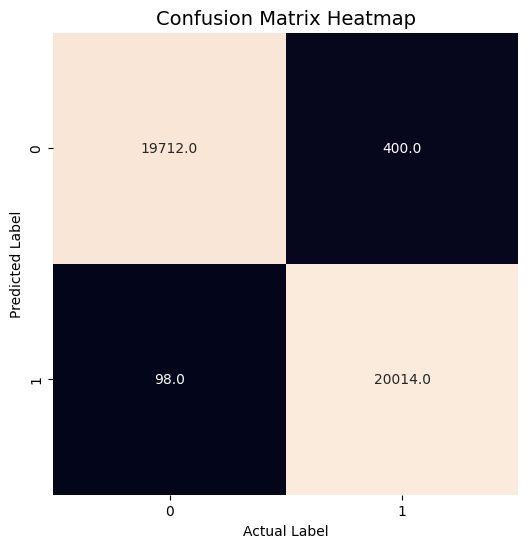

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 20014
True Negatives: 19712
False Positives: 400
False Negatives: 98
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 0.99
Sensitivity/Recall: 1.0
Specificity: 0.98
Precision: 0.98
F1 Score: 0.99
--------------------------------------------------


In [168]:
xg_boost_hpt_gs_model_train_metrics = evaluation_scores(xg_boost_hpt_gs, X_train_sm, y_train_sm_encoded)

Visualizing the Confusion Matrix with a Heatmap

**************************************************


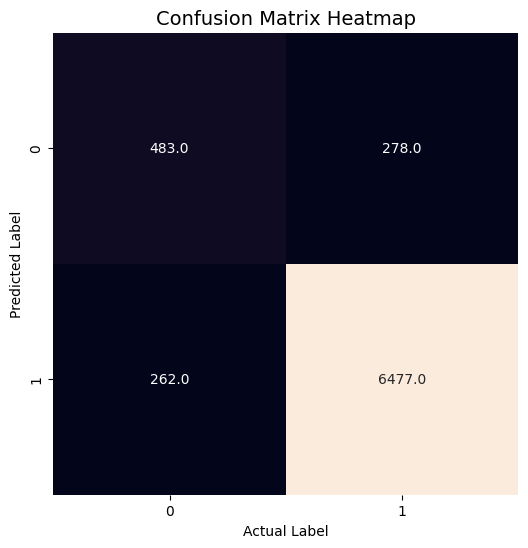

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6477
True Negatives: 483
False Positives: 278
False Negatives: 262
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 0.93
Sensitivity/Recall: 0.96
Specificity: 0.63
Precision: 0.96
F1 Score: 0.96
--------------------------------------------------


In [170]:
# Ensure y_test is also encoded to match the prediction format
y_test_encoded = label_encoder.transform(y_test)

# Make predictions (which are numeric)
y_pred_encoded = xg_boost_hpt_gs.predict(X_test)

# Convert the numeric predictions back to the original labels (optional if you want string labels later)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Getting the scores of the tuned model
xg_boost_hpt_gs_model_test_metrics = evaluation_scores(xg_boost_hpt_gs, X_test, y_test_encoded)

In [171]:
# Create a DataFrame for Logistic Regression metrics
df_xg_boost_hpt_gs_model_metrics = pd.DataFrame({
    'Metrics': ['Accuracy', 'Sensitivity/Recall', 'Specificity', 'Precision', 'F1 Score'],
    'XGBoost Hyp Train': xg_boost_hpt_gs_model_train_metrics,
    'XGBoost Hyp Test': xg_boost_hpt_gs_model_test_metrics,
})

# Set the index to be the Metrics for better readability
df_xg_boost_hpt_gs_model_metrics.set_index('Metrics', inplace=True)

# Style the DataFrame for better visualization
styled_df = df_xg_boost_hpt_gs_model_metrics.style.set_table_attributes('style="width: 50%; margin: auto; border-collapse: collapse;"') \
    .set_caption("XGBoost Classifier Hyperparameter Tuned GridSearchCV Model Metrics") \
    .format("{:.2f}") \
    .highlight_max(color='lightgreen') \
    .highlight_min(color='salmon') \
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f5f5f5'), ('color', '#333'), ('font-weight', 'bold')]
    }]) \
    .set_properties(**{'text-align': 'center'})

# Display the styled DataFrame
styled_df

### **Models Summary**


- **If high Recall and balanced metrics** are the key, the **XGBoost HPT RS** model stands out with the highest **Accuracy (0.93)** and excellent **Recall (0.96)** and **F1 Score (0.96)**, making it the most well-rounded choice for capturing positive reviews and maintaining balance.

---

<span style="color: purple;">**Conclusion**: If we are to choose an XGBoost model based on Recall and F1 Score, the **XGBoost HPT RS** model would be the best option for this sentiment-based recommendation system.</span>

## <font color = orange> <strong> <center> <u> Model Building: LightGBM </center> </strong> </font>

### LightGBM: Base Model</font>

[LightGBM] [Info] Number of positive: 20112, number of negative: 20112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.431737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 275813
[LightGBM] [Info] Number of data points in the train set: 40224, number of used features: 7512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model saved successfully as 'lgbm_base_model.pkl'.
Visualizing the Confusion Matrix with a Heatmap

**************************************************


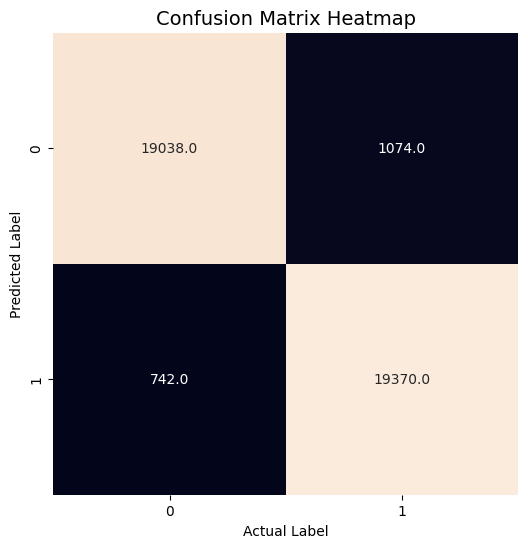

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 19370
True Negatives: 19038
False Positives: 1074
False Negatives: 742
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 0.95
Sensitivity/Recall: 0.96
Specificity: 0.95
Precision: 0.95
F1 Score: 0.96
--------------------------------------------------
Visualizing the Confusion Matrix with a Heatmap

**************************************************


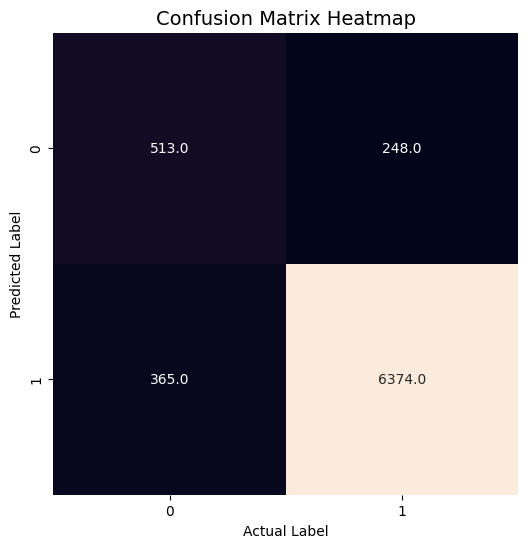

**************************************************

Values of True Positives, True Negatives, False Positives, and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6374
True Negatives: 513
False Positives: 248
False Negatives: 365
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluation Score Summary
--------------------------------------------------
Accuracy: 0.92
Sensitivity/Recall: 0.95
Specificity: 0.67
Precision: 0.96
F1 Score: 0.95
--------------------------------------------------


In [172]:
import lightgbm as lgb
import pandas as pd

# Define and fit the LightGBM model
lgbm_base_model = lgb.LGBMClassifier(random_state=42, metric='binary_logloss').fit(X_train_sm, y_train_sm)

# Save the model
save_model(lgbm_base_model, "lgbm_base_model.pkl")

# Getting the score of the base model
lgbm_base_model_train_metrics = evaluation_scores(lgbm_base_model, X_train_sm, y_train_sm)

# Getting the score of the base model
lgbm_base_model_test_metrics = evaluation_scores(lgbm_base_model, X_test, y_test)

# Create a DataFrame for LightGBM metrics
df_lgbm_base_model_metrics = pd.DataFrame({
    'Metrics': ['Accuracy', 'Sensitivity/Recall', 'Specificity', 'Precision', 'F1 Score'],
    'LightGBM Train': lgbm_base_model_train_metrics,
    'LightGBM Test': lgbm_base_model_test_metrics
})

# Set the index to be the Metrics for better readability
df_lgbm_base_model_metrics.set_index('Metrics', inplace=True)

# Style the DataFrame for better visualization
styled_df_lgbm = df_lgbm_base_model_metrics.style.set_table_attributes('style="width: 50%; margin: auto; border-collapse: collapse;"') \
    .set_caption("LightGBM Base Model Metrics") \
    .format("{:.2f}")  \
    .highlight_max(color='lightgreen') \
    .highlight_min(color='salmon') \
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f5f5f5'), ('color', '#333'), ('font-weight', 'bold')]
    }]) \
    .set_properties(**{'text-align': 'center'})

# Display the styled DataFrame
styled_df_lgbm


### **Model Summary**

The **LightGBM Base Model** offers a strong balance between high Precision and Specificity, making it ideal for situations where reducing false positives is key. It still maintains a solid Recall and F1 Score, making it a viable choice for sentiment-based recommendation systems.

## Model Evaluation

In [176]:
import pandas as pd

# Combine all DataFrames into a single DataFrame
combined_metrics_df = pd.concat([
    df_lr_base_model_metrics,
    df_lr_base_model_hpt_gs_metrics,
    df_rf_base_model_metrics,
    df_rf_hpt_gs_model_metrics,
    df_xg_boost_base_model_metrics,
    df_xg_boost_hpt_gs_model_metrics,
    df_lgbm_base_model_metrics
], axis=1)

combined_metrics_df

Logistic Regression Train  Logistic Regression Test  \
Metrics                                                                   
Accuracy                                 0.96                      0.91   
Sensitivity/Recall                       0.94                      0.92   
Specificity                              0.97                      0.78   
Precision                                0.97                      0.97   
F1 Score                                 0.96                      0.95   

                    Logistic Regression Hype Train  \
Metrics                                              
Accuracy                                       1.0   
Sensitivity/Recall                             1.0   
Specificity                                    1.0   
Precision                                      1.0   
F1 Score                                       1.0   

                    Logistic Regression Hype Test  Random Forest Train  \
Metrics                                                                  
Accuracy                                     0.92                  1.0   
Sensitivity/Recall                           0.94                  1.0   
Specificity                                  0.71                  1.0   
Precision                                    0.97                  1.0   
F1 Score                                     0.95                  1.0   

                    Random Forest Test  Random Forest Hyp Train  \
Metrics                                                           
Accuracy                          0.93                     0.86   
Sensitivity/Recall                0.97                     0.89   
Specificity                       0.61                     0.82   
Precision                         0.96                     0.84   
F1 Score                          0.96                     0.86   

                    Random Forest Hyp Test  XGBoost Train  XGBoost Test  \
Metrics                                                                   
Accuracy                              0.86           0.96          0.92   
Sensitivity/Recall                    0.88           0.98          0.96   
Specificity                           0.66           0.94          0.63   
Precision                             0.96           0.94          0.96   
F1 Score                              0.92           0.96          0.96   

                    XGBoost Hyp Train  XGBoost Hyp Test  LightGBM Train  \
Metrics                                                                   
Accuracy                         0.99              0.93            0.95   
Sensitivity/Recall               1.00              0.96            0.96   
Specificity                      0.98              0.63            0.95   
Precision                        0.98              0.96            0.95   
F1 Score                         0.99              0.96            0.96   

                    LightGBM Test  
Metrics                            
Accuracy                     0.92  
Sensitivity/Recall           0.95  
Specificity                  0.67  
Precision                    0.96  
F1 Score                     0.95

## <span style="color: purple;">**Model Selection**</span>

#### <span style="color: teal;">**Use Case Focus**</span>
- <span style="color: orange;">**Sensitivity/Recall**</span> is crucial because you want to correctly identify positive sentiments (true positives), ensuring products with genuinely positive feedback are recommended.
- <span style="color: red;">**Precision**</span> is important to avoid recommending products based on false-positive reviews.
- <span style="color: darkblue;">**F1 Score**</span> combines both Precision and Recall, ensuring a balance between identifying positive reviews and avoiding bad suggestions in cases with class imbalance.

---
<span style="color: purple;">**Conclusion**: Choosing the <span style="color: green;"><strong>XGBoost HPT GS Model</strong></span> as it provides the best balance of Recall and F1 Score with High Accuracy for our sentiment-based recommendation system.</span>

## Save Best Model into pickle

In [174]:
pickle.dump(xg_boost_hpt_gs, open("best-sentiment-classification-model.pkl","wb"))